<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Kozlov%20Alexey/InspectrumClinic_gr1_akozlov_20230612_06week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

Алексей Козлов 2023.06.12 - 2023.06.19 (6-я неделя): Балансировка датасета (Resample, метрика F1Score), построить модель FunctionalAPI

# Импорт библиотек

In [201]:
# Загрузка файлов из облака
import gdown
# Библиотека для работы с массивами данных
import numpy as np
# Библиотека для обработки и анализа данных
import pandas as pd
# Библиотека для построения графиков
import matplotlib.pyplot as plt
# Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
#Для генерации случайных чисел
import random
# Для округления
import math
import re

# Подключение класса создания модели Sequential
# Sequential – модуль для создания последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Подключение класса Dense - полносвязный слой
# Dense – линейный (полносвязный) слой. Из таких слоев будет создана ваша нейросеть
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
# utils – модуль с полезными инструментами для подготовки данных
#Используем для to_categoricall
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
# Для разбивки на выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import clear_output

# Для работы с датами
from datetime import datetime

#from keras import metrics

# Приказ Министерства здравоохранения Российской Федерации от 28.01.2021 №29Н

https://normativ.kontur.ru/document?moduleId=1&documentId=416520

используем Приложение №2

Класс I. Некоторые инфекционные и паразитарные болезни

In [202]:
# Класс I. Некоторые инфекционные и паразитарные болезни
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1vHU9NpR5eE2WuVdEjR375Fzsm2FkRpKz', None, quiet=True)

'prikazN29H_2-1.txt'

In [203]:
# from google.colab import drive #подключаю диск
# drive.mount('/content/drive')

In [204]:
# Создаем списки-классификаторы, которые потом будем использовать для пояснения решения
class29_lst0 = list()
class29_lst0.append("Класс I. Некоторые инфекционные и паразитарные болезни")
class29_lst0.append("Класс II. Новообразования")
class29_lst0.append("Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм")
class29_lst0.append("Класс IV. Болезни эндокринной системы, расстройства питания, нарушения обмена веществ")
class29_lst0.append("Класс V. Психические расстройства и расстройства поведения - по перечням и в порядке, утвержденным Правительством Российской Федерации")
class29_lst0.append("Класс VI. Болезни нервной системы")
class29_lst0.append("Класс VII. Болезни глаза и его придаточного аппарата")
class29_lst0.append("Класс VIII. Болезни уха и сосцевидного отростка")
class29_lst0.append("Класс IX. Болезни системы кровообращения")
class29_lst0.append("Класс X. Болезни органов дыхания")
class29_lst0.append("Класс XI. Болезни органов пищеварения")
class29_lst0.append("Класс XII. Болезни кожи и подкожной клетчатки")
class29_lst0.append("Класс XIII. Болезни костно-мышечной системы и соединительной ткани")
class29_lst0.append("Класс XIV. Болезни мочеполовой системы")
class29_lst0.append("Класс XV. Беременность, роды и послеродовой период")
class29_lst0.append("Класс XVII. Врожденные аномалии, деформации и хромосомные нарушения")
class29_lst0.append("Класс XIX. Травмы, отравления и некоторые другие последствия воздействий внешних причин")

# Наименование болезней
diseases29 = list()

# Создаем датафрейм для таблицы из приложения 2 приказа №29Н
df29 = pd.DataFrame(columns=['Класс', 'Болезнь', 'МКБ10', 'ВредФакторы', 'ВидыРабот'])
df29['Класс'] = df29['Класс'].astype(int)
df29['Болезнь'] = df29['Болезнь'].astype(int)
df29['МКБ10'] = df29['МКБ10'].astype(str)
df29['ВредФакторы'] = df29['ВредФакторы'].astype(str)
df29['ВидыРабот'] = df29['ВидыРабот'].astype(str)


In [205]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Код по МКБ-10` из приказа 29 по запятым и минусам
#~~~~~~~~~~~~~~~~~~~~~~~~
def mkb29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # print(f'mkb29_split> arg: {arg}')

  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      # print(f' str_lst1>: {len(str_lst1)}: {str_lst1}')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          # print(f' str_item2: {str_item2}')
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            # print(f'  str_item31: `{str_item31}`')
            # print(f'  str_item32: `{str_item32}`')
            last_dot_index31 = str_item31.rfind('.')
            last_dot_index32 = str_item32.rfind('.')
            if last_dot_index31 >= 0 or last_dot_index32 >= 0:
              str41 = str_item31
              str42 = ""
              if last_dot_index31 >= 0:
                str41, str42 = str_item31[:last_dot_index31], str_item31[last_dot_index31+1:]
              #~
              str51 = str_item32
              str52 = ""
              if last_dot_index32 >= 0:
                str51, str52 = str_item32[:last_dot_index32], str_item32[last_dot_index32+1:]
              #~
              jnum42 = 0
              jnum52 = 0
              # проверяем, что строка не пустая
              if str42:
                jnum42 = int(str42)
              if str52:
                jnum52 = int(str52)
              #~
              # print(f'str41: `{str41}`, str42: `{str42}`, jnum42: `{jnum42}`')
              # print(f'str51: `{str51}`, str52: `{str52}`, jnum52: `{jnum52}`')
              for j in range(jnum42, jnum52+1):
                if (jnum42 == j):
                  retVal.append(str_item31)
                elif (jnum52+1 == j):
                  retVal.append(str_item32)
                else:
                  retVal.append(str41 + '.' + str(j))
            else:
              str_item40 = str_item31[:1]
              str_item41 = str_item31[1:]
              str_item42 = str_item32[1:]
              num41 = int(str_item41)
              num42 = int(str_item42)
              # print(f'  str_item40: `{str_item40}`, str_item41: `{str_item41}`, str_item42: `{str_item42}`')
              # print(f'  num41: `{num41}`, num42: `{num42}`')
              for i in range(num41, num42+1):
                if i < 10:
                  retVal.append(str_item40 + '0' + str(i))
                else:
                  retVal.append(str_item40 + str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  # print(f'    retVal: {retVal}')
  return retVal

In [206]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Вредные и (или) опасные производственные факторы` из приказа 29 по запятым и минусам
# Harmful Factors
#~~~~~~~~~~~~~~~~~~~~~~~~
def hf29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # print(f'hf29_split> arg: {arg}')

  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            if str_item31.find('.') >= 0:
              last_dot_index31 = str_item31.rfind('.')
              str41, str42 = str_item31[:last_dot_index31], str_item31[last_dot_index31+1:]
              # print(f'str41: {str41}')
              # print(f'str42: {str42}')
              last_dot_index32 = str_item32.rfind('.')
              str51, str52 = str_item32[:last_dot_index32], str_item32[last_dot_index32+1:]
              # print(f'str51: {str51}')
              # print(f'str52: {str52}')
              jnum42 = int(str42)
              jnum52 = int(str52)
              # print(f'jnum42: {jnum42} - jnum52: {jnum52}')
              for j in range(jnum42, jnum52+1):
                retVal.append(str41 + '.' + str(j))
              # print(f'retVal: {retVal}')
            else:
              num31 = int(str_item31)
              num32 = int(str_item32)
              for i in range(num31, num32+1):
                retVal.append(str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  return retVal

In [207]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Виды работ` из приказа 29 по запятым и минусам
# Types of work
#~~~~~~~~~~~~~~~~~~~~~~~~
def tow29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            num31 = int(str_item31)
            num32 = int(str_item32)
            for i in range(num31, num32+1):
              retVal.append(str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  return retVal

In [208]:
def addClassToAccumulator29(file_name29, class29_inx, df_29):
  '''
    Чтение текстового файла и добавление его значений по спискам
    вход:
        file_name29: имя текстового файла
        class29_inx: индекс класса в списке class29_lst0
    выход:
        df_29: дополненный дата фрейм
  '''
  # print(f'file_name29: `{file_name29}`')
  # print(f'class29_inx: {class29_inx}')

  # чтение файла и создание списка строк
  with open('/content/'+file_name29, 'r') as file29:
    lines29 = file29.readlines()

  # print(f'{len(lines29)}: {lines29}')

  for i in range(len(lines29)):
    # print(f'{i}->{len(lines29)}: {lines29[i]}')
    str1 = lines29[i].strip()
    # разбиваем строку по вертикальным линиям
    str_lst1 = str1.split('|')
    if 4 == len(str_lst1):
      # 0: `а) Активный туберкулез.... `
      # 1: `A15 - A19`
      # 2: `1 - 5`
      # 3: `6 - 27`
      #~~~0 ~ Наименование болезней
      diseases29.append(str_lst1[0].strip())
      diseases29_inx = len(diseases29) - 1
      # print(f'diseases29_inx: {diseases29_inx}, len(diseases29): {len(diseases29)}, {diseases29}')
      #~~~1 ~ МКБ-10
      mkb29_lst = mkb29_split(str_lst1[1].strip())
      if len(mkb29_lst) < 1:
        print(f'ОШИБКА: неверное значение МКБ: {file_name29}')
        continue
      # print(f'mkb29_lst: `{mkb29_lst}`')
      #~~~2 ~ Вредные факторы
      hf29_lst = hf29_split(str_lst1[2].strip())
      hf29_str = ""
      if len(hf29_lst) > 0:
        hf29_str = ','.join(hf29_lst)
      # print(f'hf29_lst: `{hf29_lst}`')
      # print(f'hf29_str: `{hf29_str}`')
      #~~~3 ~ Виды работ
      tow29_lst = tow29_split(str_lst1[3].strip())
      tow29_str = ""
      if len(tow29_lst) > 0:
        tow29_str = ','.join(tow29_lst)
      # print(f'tow29_lst: `{tow29_lst}`')
      # print(f'tow29_str: `{tow29_str}`')
      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~~~~добавляю сформированне строки в датафрейм
      for j in range(len(mkb29_lst)):
        # print(f'{j}: {mkb29_lst[j]}')
        newrow_29 = {'Класс': class29_inx, 'Болезнь': diseases29_inx, 'МКБ10': mkb29_lst[j], 'ВредФакторы': hf29_str, 'ВидыРабот': tow29_str}
        df_29 = pd.concat([df_29, pd.DataFrame(newrow_29, index=[0])], ignore_index=True)
    else:
      print(f'ОШИБКА: неверное число данных в колонках: {file_name29}')

  return df_29

In [209]:
class29_inx = 0
df29 = addClassToAccumulator29('prikazN29H_2-1.txt', class29_inx, df29);

print(f'размеры датафрейма: df29: {df29.shape}')
df29.head(3)

размеры датафрейма: df29: (74, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
0,0,0,A00,,"23,24,25,26,27"
1,0,0,A01,,"23,24,25,26,27"
2,0,0,A02,,"23,24,25,26,27"


In [210]:
# Класс II. Новообразования
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1MdbpmwXB80XsB0mAoAyZO59q9qbl7pfm', None, quiet=True)

'prikazN29H_2-2.txt'

In [211]:
df29 = addClassToAccumulator29('prikazN29H_2-2.txt', 1, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (371, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
368,1,14,D34,Р,
369,1,14,D35,Р,
370,1,14,D36,Р,


In [212]:
# Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1vapIs6qQ3F4SYoax8mY2GKbP86aUHUXj', None, quiet=True)

'prikazN29H_2-3.txt'

In [213]:
df29 = addClassToAccumulator29('prikazN29H_2-3.txt', 2, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (571, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
568,2,19,D87,"1.12,1.15.1,1.21,1.24,1.27,1.34,1.37.1.1,1.37....",
569,2,19,D88,"1.12,1.15.1,1.21,1.24,1.27,1.34,1.37.1.1,1.37....",
570,2,19,D89,"1.12,1.15.1,1.21,1.24,1.27,1.34,1.37.1.1,1.37....",


In [214]:
# Класс IV. Болезни эндокринной системы, расстройства питания, нарушения обмена веществ
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1ViboYoy-SdVyJ-004iHQDqQb1PAt8fjC', None, quiet=True)

'prikazN29H_2-4.txt'

In [215]:
df29 = addClassToAccumulator29('prikazN29H_2-4.txt', 3, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

ОШИБКА: неверное число данных в колонках: prikazN29H_2-4.txt
размеры датафрейма: df29: (640, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
637,3,22,E27,,"19,20,21"
638,3,22,E66,,"19,20,21"
639,3,22,E84,,"19,20,21"


In [216]:
# Класс V. Психические расстройства и расстройства поведения - по перечням и в порядке, утвержденным Правительством Российской Федерации
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1ZwSc-gWcwQRyXeNjrS3njymzTpKk8NWd', None, quiet=True)

'prikazN29H_2-5.txt'

In [217]:
df29 = addClassToAccumulator29('prikazN29H_2-5.txt', 4, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (680, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
677,4,24,F19,1.52.6,
678,4,25,F98.5,,"19,20,21"
679,4,25,F98.6,,"19,20,21"


In [218]:
# Класс VI. Болезни нервной системы
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1dp2M6hegEX2VSBv1l7aD8lAjVm9gSymx', None, quiet=True)

'prikazN29H_2-6.txt'

In [219]:
df29 = addClassToAccumulator29('prikazN29H_2-6.txt', 5, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (829, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
826,5,45,G93,"1,2,3,4,5","6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22"
827,5,46,G95,"1,2,3,4,5","6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22"
828,5,46,G99.2,"1,2,3,4,5","6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22"


In [220]:
# Класс VII. Болезни глаза и его придаточного аппарата
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1Hex8Ij2C_IT49Vs2EMyf6W731IN4RS9j', None, quiet=True)

'prikazN29H_2-7.txt'

In [221]:
df29 = addClassToAccumulator29('prikazN29H_2-7.txt', 6, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (992, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
989,6,65,H50.0,,"6,9,10,14,15,16,17,19"
990,6,65,H53.4,,"6,9,10,14,15,16,17,19"
991,6,66,H53.5,,"19,20,21"


In [222]:
# Класс VIII. Болезни уха и сосцевидного отростка
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1Mrey5pmmVPeJsKixsP2ctAEQRu6aNEug', None, quiet=True)

'prikazN29H_2-8.txt'

In [223]:
df29 = addClassToAccumulator29('prikazN29H_2-8.txt', 7, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (1007, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
1004,7,68,H83.3,"1.47.2,4.3.2,4.4","6,7,8,9,10,12,13,14,15,16,19,20,21,22"
1005,7,68,H90,"1.47.2,4.3.2,4.4","6,7,8,9,10,12,13,14,15,16,19,20,21,22"
1006,7,68,H91,"1.47.2,4.3.2,4.4","6,7,8,9,10,12,13,14,15,16,19,20,21,22"


In [224]:
# Класс IX. Болезни системы кровообращения
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1SDwoLXQtrWUk1l-3Hw45jkIfl1qEhXbq', None, quiet=True)

'prikazN29H_2-9.txt'

In [225]:
df29 = addClassToAccumulator29('prikazN29H_2-9.txt', 8, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (1223, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
1220,8,85,I87,"4.3,4.7,5.1","11.4,19,20,21"
1221,8,85,I88,"4.3,4.7,5.1","11.4,19,20,21"
1222,8,85,I89,"4.3,4.7,5.1","11.4,19,20,21"


In [226]:
# Класс X. Болезни органов дыхания
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1L4RZx4jiQP78S6I3Cwk39SEkPpVe1Kvk', None, quiet=True)

'prikazN29H_2-10.txt'

In [227]:
df29 = addClassToAccumulator29('prikazN29H_2-10.txt', 9, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (1505, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
1502,9,96,J96,"1.4,1.5,1.7,1.8,1.9,1.19,1.23,1.26,1.29,1.31,1...","14,16,17,19,21"
1503,9,96,J97,"1.4,1.5,1.7,1.8,1.9,1.19,1.23,1.26,1.29,1.31,1...","14,16,17,19,21"
1504,9,96,J98,"1.4,1.5,1.7,1.8,1.9,1.19,1.23,1.26,1.29,1.31,1...","14,16,17,19,21"


In [228]:
# Класс XI. Болезни органов пищеварения
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1xDuE6eKnJ3MYZBC2m3i1sF87IOCvW6HZ', None, quiet=True)

'prikazN29H_2-11.txt'

In [229]:
df29 = addClassToAccumulator29('prikazN29H_2-11.txt', 10, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (1656, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
1653,10,111,K84,,"19.1,20"
1654,10,111,K85,,"19.1,20"
1655,10,111,K86,,"19.1,20"


In [230]:
# Класс XII. Болезни кожи и подкожной клетчатки
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=19eBqx-65fPNFZ4F4xoekF3fSBs-p11hq', None, quiet=True)

'prikazN29H_2-12.txt'

In [231]:
df29 = addClassToAccumulator29('prikazN29H_2-12.txt', 11, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (2151, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
2148,11,116,L96,4.1,
2149,11,116,L97,4.1,
2150,11,116,L98,4.1,


In [232]:
# Класс XIII. Болезни костно-мышечной системы и соединительной ткани
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=12doWmAoiZ2P8MFLKdUGfKRDd1pwgy7RV', None, quiet=True)

'prikazN29H_2-13.txt'

In [233]:
df29 = addClassToAccumulator29('prikazN29H_2-13.txt', 12, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (2279, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
2276,12,120,M33,,"19,21"
2277,12,120,M34,,"19,21"
2278,12,120,M35,,"19,21"


In [234]:
# Класс XIV. Болезни мочеполовой системы
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=183q7ILQKzAtSMWx5bn9wNDCK8-OIb2Et', None, quiet=True)

'prikazN29H_2-14.txt'

In [235]:
df29 = addClassToAccumulator29('prikazN29H_2-14.txt', 13, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (2379, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
2376,13,121,N97,"1,2,3,4,5","6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22"
2377,13,121,N98,"1,2,3,4,5","6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22"
2378,13,121,N99,"1,2,3,4,5","6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22"


In [236]:
# Класс XV. Беременность, роды и послеродовой период
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1JW7lE9CbVOLAbgpAILJqFQ1PNtp84BIs', None, quiet=True)

'prikazN29H_2-15.txt'

In [237]:
df29 = addClassToAccumulator29('prikazN29H_2-15.txt', 14, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (2679, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
2676,14,124,O97,"1,2,3,4,5",
2677,14,124,O98,"1,2,3,4,5",
2678,14,124,O99,"1,2,3,4,5",


In [238]:
# Класс XVII. Врожденные аномалии, деформации и хромосомные нарушения
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1817q3FmaSPid-ZUN9DWTZOBGi5fLb1fP', None, quiet=True)

'prikazN29H_2-17.txt'

In [239]:
df29 = addClassToAccumulator29('prikazN29H_2-17.txt', 15, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (3079, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
3076,15,128,Q97,,"19,20,21"
3077,15,128,Q98,,"19,20,21"
3078,15,128,Q99,,"19,20,21"


In [240]:
# Класс XIX. Травмы, отравления и некоторые другие последствия воздействий внешних причин
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1KY71BsK_f-5sATwqEB34AlH692vm7_VJ', None, quiet=True)

'prikazN29H_2-19.txt'

In [241]:
df29 = addClassToAccumulator29('prikazN29H_2-19.txt', 16, df29);
print(f'размеры датафрейма: df29: {df29.shape}')
df29.tail(3)

размеры датафрейма: df29: (3113, 5)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот
3110,16,133,T96,"1,2,3,4,5","6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22"
3111,16,133,T97,"1,2,3,4,5","6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22"
3112,16,133,T98,"1,2,3,4,5","6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22"


## Пример работы с df29

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Пример получения информации по коду МКБ-10
#~~~~~~~~~~~~~~~~~~~~~~~~

mkb_10 = 'A16'

inxs29 = df29.index[df29['МКБ10'] == mkb_10].tolist()
print(f'{len(inxs29)}: {inxs29}')

for i in range(len(inxs29)):
  print()
  print('='*50)
  print(f'{i}->{len(inxs29)-1}')
  elems29 = df29.iloc[inxs29[i]].values
  print(f'{len(elems29)}: {elems29}')
  #~Класс
  print('-'*50)
  print('Класс:')
  ielem = int(elems29[0])
  print(f'  {ielem}: {class29_lst0[ielem]}')
  #~Болезнь
  print('-'*50)
  print('Наименование болезней, степень нарушения функции организма:')
  ielem = int(elems29[1])
  print(f'  {ielem}: {diseases29[ielem]}')
  #~МКБ10
  print('-'*50)
  print('Код по МКБ-10:')
  print(f'  {elems29[2]}')
  #~ВредФакторы
  print('-'*50)
  print('Вредные и (или) опасные производственные факторы:')
  print(f'  {elems29[3]}')
  #~ВидыРабот
  print('-'*50)
  print('Виды работ :')
  print(f'  {elems29[4]}')

2: [11, 16]

0->1
5: [0 1 'A16' '' '']
--------------------------------------------------
Класс:
  0: Класс I. Некоторые инфекционные и паразитарные болезни
--------------------------------------------------
Наименование болезней, степень нарушения функции организма:
  1: Туберкулез органов дыхания, других органов и систем:
--------------------------------------------------
Код по МКБ-10:
  A16
--------------------------------------------------
Вредные и (или) опасные производственные факторы:
  
--------------------------------------------------
Виды работ :
  

1->1
5: [0 2 'A16' '1,2,3,4,5'
 '6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27']
--------------------------------------------------
Класс:
  0: Класс I. Некоторые инфекционные и паразитарные болезни
--------------------------------------------------
Наименование болезней, степень нарушения функции организма:
  2: а) Активный туберкулез органов дыхания; последствия хирургического лечения или выраженные остаточны

# Загрузка датасета, отображение сводной информации

In [ ]:
# Загрузка файла датасета от 2023.05.08
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx'
url2 = '/content/InspectrumClinic1.xlsx'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx
To: /content/InspectrumClinic1.xlsx
100%|██████████| 32.4M/32.4M [00:03<00:00, 10.3MB/s]


'/content/InspectrumClinic1.xlsx'

In [ ]:
# Чтение данных (df - DataFrame)
df1 = pd.read_excel(url2)

In [ ]:
# Выведем информацию о заполненности ячеек каждого признака
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 4587 entries, ДокументПрохождениеМедосмотра to Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
dtypes: bool(1), datetime64[ns](43), float64(1253), object(3290)
memory usage: 69.3+ MB


In [ ]:
print(f'размеры датафрейма: df1: {df1.shape}')

размеры датафрейма: df1: (1982, 4587)


In [ ]:
# общее количество пропусков во всей таблице
nan_cell_count = df1.isna().sum().sum()
# Переведем полученное значение в проценты. Для этого поделим количество пропусков на количество ячеек и умножим на 100:
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

общее количество пропусков во всей таблице: 8106978, 89.17%


# Балансировка датасета Resample, графическое представление

In [ ]:
# Целевая колонка 'ЗаключениеМК'
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ЗаключениеМК": число строк с пустыми значениями: 407
10: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель']


In [ ]:
# Подсчитаем число строк по каждому целевому значению
# Получаем список значений колонки
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1.shape[0]: {df1.shape[0]}: len(col_lst): {len(col_lst)}, col_lst: {col_lst}')

# 6: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']

lst0 = list() #0 - ВременноНегоден
lst1 = list() #1 - ГоденСКоррекциейЗрения
lst2 = list() #2 - ГоденБезРаботНаВысотах
lst3 = list() #3 - НуждаетсяВДообследованииИЛечении
lst4 = list() #4 - ОграниченноГоден
lst5 = list() #5 - Годен

# Подсчитываем число целевых значений по категориям
# и заполняем списки индексов соответствующих значений
# Пробегаем по всем строкам текущей колонки
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      if not (('машинист бульдозера' == i_elem) or ('Газоспасатель' == i_elem) or (' Газоспасатель' == i_elem)):
        # print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
        if 'ВременноНегоден' == i_elem:
          lst0.append(i)
        elif 'ГоденСКоррекциейЗрения' == i_elem:
          lst1.append(i)
        elif 'ГоденБезРаботНаВысотах' == i_elem:
          lst2.append(i)
        elif 'НуждаетсяВДообследованииИЛечении' == i_elem:
          lst3.append(i)
        elif 'ОграниченноГоден' == i_elem:
          lst4.append(i)
        elif 'Годен' == i_elem:
          lst5.append(i)
        else:
          print(f'{i}->{df1.shape[0]}: i_elem: {i_elem} -> НЕИЗВЕСТНЫЙ ИНДЕКС-ТИП')

print(f'df1 число строк: {df1.shape[0]}')

print(f'0: ВременноНегоден: {len(lst0)}')
print(f'1: ГоденСКоррекциейЗрения: {len(lst1)}')
print(f'2: ГоденБезРаботНаВысотах: {len(lst2)}')
print(f'3: НуждаетсяВДообследованииИЛечении: {len(lst3)}')
print(f'4: ОграниченноГоден: {len(lst4)}')
print(f'5: Годен: {len(lst5)}')

print('проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:')
print(f'  {df1.shape[0]} -> {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)+len(lst5)}')

df1 число строк: 1982
0: ВременноНегоден: 9
1: ГоденСКоррекциейЗрения: 123
2: ГоденБезРаботНаВысотах: 1
3: НуждаетсяВДообследованииИЛечении: 2
4: ОграниченноГоден: 2
5: Годен: 1434
проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:
  1982 -> 1571


0: не годен: 9
1: ограниченно годен: 128
2: годен: 1434


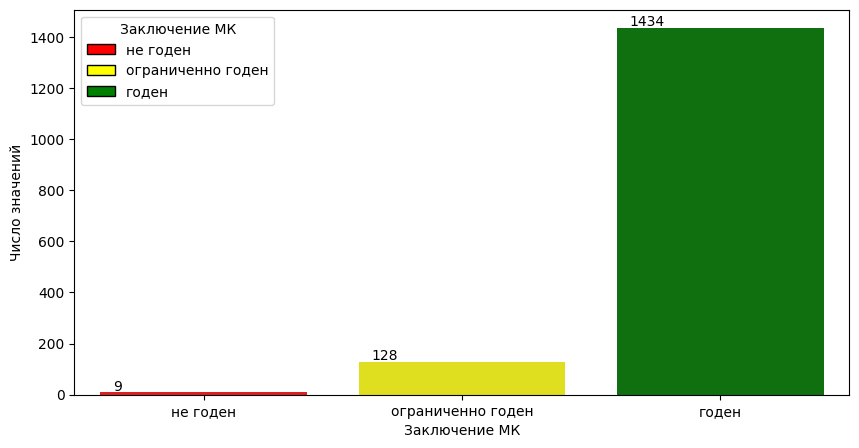

In [ ]:
# Визуальная оценка сбалансированности датасета до ресемплинга

from matplotlib.patches import Patch

conclusion_lst = ['не годен', 'ограниченно годен', 'годен']

conclusion_count_arr = np.zeros(3, dtype=int)
# не годен
conclusion_count_arr[0] = len(lst0)
# ограниченно годен
conclusion_count_arr[1] = len(lst1)+len(lst2)+len(lst3)+len(lst4)
# годен
conclusion_count_arr[2] = len(lst5)

print(f'0: не годен: {conclusion_count_arr[0]}')
print(f'1: ограниченно годен: {conclusion_count_arr[1]}')
print(f'2: годен: {conclusion_count_arr[2]}')

plt.figure(figsize=(10, 5))
plot0 = sns.barplot(x=conclusion_lst, y=conclusion_count_arr, palette=["red", "yellow", "green"])
plt.xlabel("Заключение МК")
plt.ylabel("Число значений")
legend_elements = [Patch(facecolor='red', edgecolor='black', label='не годен'),
                   Patch(facecolor='yellow', edgecolor='black', label='ограниченно годен'),
                   Patch(facecolor='green', edgecolor='black', label='годен')]
plt.legend(handles=legend_elements, title="Заключение МК")
# выводим значения над столбиками
for p in plot0.patches:
  plot0.annotate(text='{}'.format(int(p.get_height())),xy=(p.get_x() + 0.05, p.get_height() + 7.5))
plt.show()

In [ ]:
# создаем копию нужных строк и добавляем их в отдельный df
adf0 = df1.loc[lst0].copy()
print(f'размеры датафрейма adf0: {adf0.shape}, len(lst0): {len(lst0)}')

adf1 = df1.loc[lst1].copy()
print(f'размеры датафрейма adf1: {adf1.shape}, len(lst1): {len(lst1)}')

adf2 = df1.loc[lst2].copy()
print(f'размеры датафрейма adf2: {adf2.shape}, len(lst2): {len(lst2)}')

adf3 = df1.loc[lst3].copy()
print(f'размеры датафрейма adf3: {adf3.shape}, len(lst3): {len(lst3)}')

adf4 = df1.loc[lst4].copy()
print(f'размеры датафрейма adf4: {adf4.shape}, len(lst4): {len(lst4)}')

размеры датафрейма adf0: (9, 4587), len(lst0): 9
размеры датафрейма adf1: (123, 4587), len(lst1): 123
размеры датафрейма adf2: (1, 4587), len(lst2): 1
размеры датафрейма adf3: (2, 4587), len(lst3): 2
размеры датафрейма adf4: (2, 4587), len(lst4): 2


In [ ]:
print(f'размеры датафрейма: df1: {df1.shape}')

# добавляем новый df в исходный df

# for i in range(2):
for i in range(1):
  for j in range(80):
    df1 = pd.concat([df1, adf0], ignore_index=True)
  df1 = pd.concat([df1, adf1], ignore_index=True)
  for j in range(200):
    df1 = pd.concat([df1, adf2], ignore_index=True)
  for j in range(100):
    df1 = pd.concat([df1, adf3], ignore_index=True)
    df1 = pd.concat([df1, adf4], ignore_index=True)

print('='*50)
print(f'размеры датафрейма: df1: {df1.shape}')

размеры датафрейма: df1: (1982, 4587)
размеры датафрейма: df1: (3425, 4587)


In [ ]:
# Смотрим новые значения целевой колонки
lst0.clear()
lst1.clear()
lst2.clear()
lst3.clear()
lst4.clear()
lst5.clear()

col_lst = df1.iloc[:, col_inx].tolist()
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  if (i_elem == i_elem):
    if i_elem:
      if not (('машинист бульдозера' == i_elem) or ('Газоспасатель' == i_elem) or (' Газоспасатель' == i_elem)):
        if 'ВременноНегоден' == i_elem:
          lst0.append(i)
        elif 'ГоденСКоррекциейЗрения' == i_elem:
          lst1.append(i)
        elif 'ГоденБезРаботНаВысотах' == i_elem:
          lst2.append(i)
        elif 'НуждаетсяВДообследованииИЛечении' == i_elem:
          lst3.append(i)
        elif 'ОграниченноГоден' == i_elem:
          lst4.append(i)
        elif 'Годен' == i_elem:
          lst5.append(i)
        else:
          print(f'{i}->{df1.shape[0]}: i_elem: {i_elem} -> НЕИЗВЕСТНЫЙ ИНДЕКС-ТИП')

print(f'df1 число строк: {df1.shape[0]}')

print(f'0: ВременноНегоден: {len(lst0)}')
print(f'1: ГоденСКоррекциейЗрения: {len(lst1)}')
print(f'2: ГоденБезРаботНаВысотах: {len(lst2)}')
print(f'3: НуждаетсяВДообследованииИЛечении: {len(lst3)}')
print(f'4: ОграниченноГоден: {len(lst4)}')
print(f'5: Годен: {len(lst5)}')

print('проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:')
print(f'  {df1.shape[0]} -> {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)+len(lst5)}')
print(f'  Годен: {len(lst5)}')
print(f'  Негоден, Ограниченно годен: {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)}')

df1 число строк: 3425
0: ВременноНегоден: 729
1: ГоденСКоррекциейЗрения: 246
2: ГоденБезРаботНаВысотах: 201
3: НуждаетсяВДообследованииИЛечении: 202
4: ОграниченноГоден: 202
5: Годен: 1434
проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:
  3425 -> 3014
  Годен: 1434
  Негоден, Ограниченно годен: 1580


0: не годен: 729
1: ограниченно годен: 851
2: годен: 1434


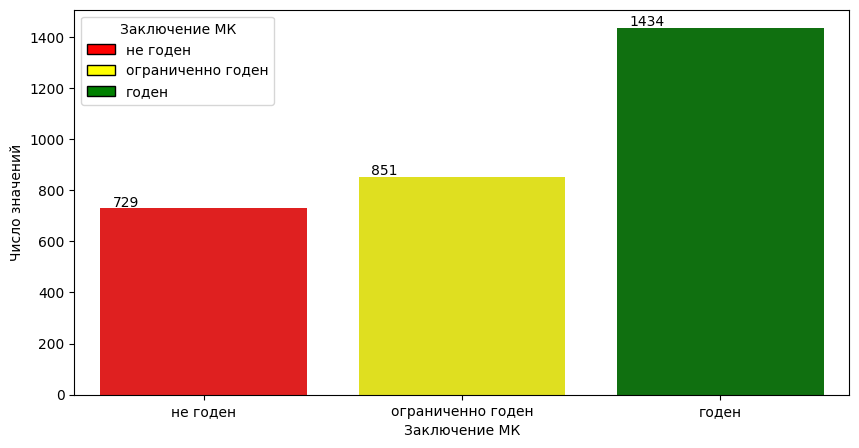

In [ ]:
# Визуальная оценка сбалансированности датасета после ресемплинга

# не годен
conclusion_count_arr[0] = len(lst0)
# ограниченно годен
conclusion_count_arr[1] = len(lst1)+len(lst2)+len(lst3)+len(lst4)
# годен
conclusion_count_arr[2] = len(lst5)

print(f'0: не годен: {conclusion_count_arr[0]}')
print(f'1: ограниченно годен: {conclusion_count_arr[1]}')
print(f'2: годен: {conclusion_count_arr[2]}')

plt.figure(figsize=(10, 5))
plot1 = sns.barplot(x=conclusion_lst, y=conclusion_count_arr, palette=["red", "yellow", "green"])
plt.xlabel("Заключение МК")
plt.ylabel("Число значений")
legend_elements = [Patch(facecolor='red', edgecolor='black', label='не годен'),
                   Patch(facecolor='yellow', edgecolor='black', label='ограниченно годен'),
                   Patch(facecolor='green', edgecolor='black', label='годен')]
plt.legend(handles=legend_elements, title="Заключение МК")
# выводим значения над столбиками
for p in plot1.patches:
  plot1.annotate(text='{}'.format(int(p.get_height())),xy=(p.get_x() + 0.05, p.get_height() + 7.5))
plt.show()

In [ ]:
del lst0
del lst1
del lst2
del lst3
del lst4
del lst5

del adf0
del adf1
del adf2
del adf3
del adf4

del conclusion_count_arr

# Удаление из датафрейма строк с пустыми и ошибочными целевыми значениями

In [ ]:
# Целевая колонка 'ЗаключениеМК'
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ЗаключениеМК": число строк с пустыми значениями: 407
10: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель']


In [ ]:
# Удаляем строки с пустыми и запрещенными значениями в целевой колонке 'ЗаключениеМК'
# nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель'
df1 = df1.drop(df1[(df1['ЗаключениеМК'].isnull()) | (df1['ЗаключениеМК'] == 'машинист бульдозера') | (df1['ЗаключениеМК'] == 'Газоспасатель') | (df1['ЗаключениеМК'] == ' Газоспасатель') ].index)
print(f'размеры датафрейма после удаления строк: {df1.shape}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

размеры датафрейма после удаления строк: (3014, 4587)
6: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']


# Создаем второй датафрейм для обучения нейросети

In [ ]:
# Заполняем колонку ЗаключениеМКК категориальными признаками
# по данным колонки ЗаключениеМК
# 0 - не годен, 1 - ограниченно годен, 2 - годен
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ЗаключениеМК'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getConclusionCategory(arg):
  '''
    Получение целевого категориального значения по текстовому описанию
    вход:
        arg: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']
    выход:
        0 - не годен, 1 - ограниченно годен, 2 - годен
  '''
  if ('ГоденСКоррекциейЗрения' == arg) or ('ГоденБезРаботНаВысотах' == arg) or ('ОграниченноГоден' == arg):
    retVal = 1
  elif ('НуждаетсяВДообследованииИЛечении' == arg) or ('ВременноНегоден' == arg):
    retVal = 0
  else:
    retVal = 2

  return retVal

In [ ]:
# Получаем список значений колонки
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()

# создаем numpy массив integer из нулей, число элементов равно числу строк нашего data frame
i_arr = np.zeros(df1.shape[0], dtype=int)

# Заполняем массив категориальными индексами
for i in range(df1.shape[0]):
  i_arr[i] = getConclusionCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(i_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ЗаключениеМКК' в DataFrame 'df1' из массива 'ohe_lst2'
df1 = df1.assign(ЗаключениеМКК=ohe_lst2)

# создаем новый датафрейм, в который будем заносить колонки для обучения нейросети
# и копируем колонку 'ЗаключениеМКК' в новый дата фрэйм
df2 = df1[['ЗаключениеМКК']].copy()
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 1)


,ЗаключениеМКК
0,"[0, 0, 1]"
1,"[0, 0, 1]"
2,"[0, 1, 0]"


# Категориальные признаки

## Возраст

In [ ]:
nan_lst = df1[df1['КлиентДатаРождения'].isnull()].index
print(f'"КлиентДатаРождения": число строк с пустыми значениями: {len(nan_lst)}')

"КлиентДатаРождения": число строк с пустыми значениями: 0


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода Возраст клиента
#~~~~~~~~~~~~~~~~~~~~~~~~
# Возраст клиента = ДатаЗавершенияМедосмотра - КлиентДатаРождения
#~~~~~~~~~~~~~~~~~~~~~~~~
def getAgeCategory(ageN, ageClassCount):
  '''
    Возраст превращаем в категориальный: до 18лет, далее через 5, всего 11 классов
    вход:
        ageN: возраст в годах
        ageClassCount: число классов
    выход:
        retVal: индекс категории: 0-17: 0, 18-22: 1, 23-27: 2, ...., 73..: 10
  '''
  #age2 = int((arg-13)/5)
  age2 = (ageN-13)/5
  retVal = max(0, min((ageClassCount-1),age2))
  return retVal

In [ ]:
age_class_count = 11

# КлиентДатаРождения
col_inx = df1.columns.get_loc('КлиентДатаРождения')
col_lst = df1.iloc[:, col_inx].tolist()

datetime_lst1 = []
for time_stamp in col_lst:
  datetime_obj = time_stamp.to_pydatetime()
  datetime_lst1.append(datetime_obj)

# ДатаЗавершенияМедосмотра
nan_lst = df1[df1['ДатаЗавершенияМедосмотра'].isnull()].index
print(f'"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')
col_inx = df1.columns.get_loc('ДатаЗавершенияМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()

datetime_lst2 = []
for time_stamp in col_lst:
  datetime_obj = time_stamp.to_pydatetime()
  datetime_lst2.append(datetime_obj)

# рассчитываю возраст клиента
for i in range(df1.shape[0]):
  delta_dates21 = datetime_lst2[i].date() - datetime_lst1[i].date()
  delta_days21 = delta_dates21.days
  delta_years21 = delta_days21 // 365
  i_arr[i] = getAgeCategory(delta_years21, age_class_count)

# Преобразование массива в формат one_hot_encoding
i_arr2 = utils.to_categorical(i_arr, age_class_count)
ohe_lst2 = i_arr2.astype(int).tolist()

# добавляем новую колонку 'Возраст' в 'df2'
df2 = df2.assign(Возраст=ohe_lst2)

# удаление переменных, освобождение памяти
del datetime_lst1
del datetime_lst2

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: 0
размеры датафрейма: df1: (3014, 4588), df2: (3014, 2)


,ЗаключениеМКК,Возраст
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


## КлиентПол

In [ ]:
nan_lst = df1[df1['КлиентПол'].isnull()].index
print(f'"КлиентПол": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['КлиентПол'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"КлиентПол": число строк с пустыми значениями: 0
2: ['Женский', 'Мужской']


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'КлиентПол'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getGenderCategory(arg):
  '''
    Бинарный пол клиента
    вход:
        arg: ['Женский', 'Мужской']
    выход:
        retVal: 0 - Женский, 1 - Мужской
  '''
  if 'Женский' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [ ]:
col_inx = df1.columns.get_loc('КлиентПол')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getGenderCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# добавляем новую колонку 'КлиентПол' в 'df2'
df2 = df2.assign(КлиентПол=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 3)


,ЗаключениеМКК,Возраст,КлиентПол
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1


## ТипМедосмотра

In [ ]:
nan_lst = df1[df1['ТипМедосмотра'].isnull()].index
print(f'"ТипМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ТипМедосмотра'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ТипМедосмотра": число строк с пустыми значениями: 0
2: ['Периодический', 'Предварительный']


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ТипМедосмотра'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getTypeMedExaminationCategory(arg):
  '''
    Бинарный Тип Медосмотра
    вход:
        arg: ['Периодический', 'Предварительный']
    выход:
        retVal: 0 - Периодический, 1 - Предварительный
  '''
  if 'Периодический' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [ ]:
col_inx = df1.columns.get_loc('ТипМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getTypeMedExaminationCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# добавляем новую колонку 'ТипМедосмотра' в 'df2'
df2 = df2.assign(ТипМедосмотра=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 4)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0


## ПсихОсвидетельствование

In [ ]:
nan_lst = df1[df1['ПсихОсвидетельствование'].isnull()].index
print(f'"ПсихОсвидетельствование": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ПсихОсвидетельствование'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ПсихОсвидетельствование": число строк с пустыми значениями: 0
2: [False, True]


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ПсихОсвидетельствование'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getPsychicExaminationCategory(arg):
  '''
    Бинарный Тип ПсихОсвидетельствование
    вход:
        arg: [False, True]
    выход:
        retVal: 0 - False, 1 - True
  '''
  if False == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [ ]:
col_inx = df1.columns.get_loc('ПсихОсвидетельствование')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getPsychicExaminationCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# добавляем новую колонку 'ПсихОсвидетельствование' в 'df2'
df2 = df2.assign(ПсихОсвидетельствование=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 5)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0


## ДиспансернаяГруппа

In [ ]:
nan_lst = df1[df1['ДиспансернаяГруппа'].isnull()].index
print(f'"ДиспансернаяГруппа": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ДиспансернаяГруппа'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ДиспансернаяГруппа": число строк с пустыми значениями: 269
5: ['I', 'IIIа', 'II', 'IIIб', nan]


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ДиспансернаяГруппа'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getDispensaryGroupCategory(arg):
  '''
    Категориальный Тип ДиспансернаяГруппа
    вход:
        один из элементов массива уникальных значений: ['I', 'IIIа', 'II', 'IIIб']
    выход:
        retVal: индекс элемента в массиве уникальных значений:
          0 - nan, 1 - 'I', 2 - 'IIIа', 3 - 'II', 4 - 'IIIб'
  '''
  if 'I' == arg:
    retVal = 1
  elif 'IIIа' == arg:
    retVal = 2
  elif 'II' == arg:
    retVal = 3
  elif 'IIIб' == arg:
    retVal = 4
  else:
    retVal = 0

  return retVal

In [ ]:
dispensary_class_count = 5

col_inx = df1.columns.get_loc('ДиспансернаяГруппа')
col_lst = df1.iloc[:, col_inx].tolist()

# Заполняем массив категориальными индексами
for i in range(df1.shape[0]):
  i_arr[i] = getDispensaryGroupCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding (5-классов)
i_arr2 = utils.to_categorical(i_arr, dispensary_class_count)
ohe_lst2 = i_arr2.astype(int).tolist()

# добавляем новую колонку 'ДиспансернаяГруппа' в 'df2'
df2 = df2.assign(ДиспансернаяГруппа=ohe_lst2)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 6)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]"


In [ ]:
df2.tail(2)

,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа
3423,"[0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]"
3424,"[0, 1, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,0,0,"[0, 1, 0, 0, 0]"


## ВредныеФакторы

In [ ]:
an_lst = df1[df1['ВредныеФакторы'].isnull()].index
print(f'"ВредныеФакторы": число строк с пустыми значениями: {len(nan_lst)}')

"ВредныеФакторы": число строк с пустыми значениями: 269


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки по запятым
#~~~~~~~~~~~~~~~~~~~~~~~~
def comma_string_split(arg):
  '''
    Расщепление строки по запятым, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых
    выход:
        retVal: список строк
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # приводим к нижнему регистру, удаляем пробелы в начале и конце слова
      #str1 = arg.lower().strip()
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          retVal.append(str_item2)

  return retVal

In [ ]:
# Формируем список уникальных значений вредных факторов
# Harmful Factors
u_hf_lst = list()

col_inx = df1.columns.get_loc('ВредныеФакторы')
col_lst = df1.iloc[:, col_inx].tolist()
#print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  #print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      #print(f'  {len(elem_lst)}: {elem_lst}')
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          #print(f'    elem1_lst: {elem1_lst}')
          if len(u_hf_lst) > 0:
            # проверяем, что этого элемента нет в списке
            flag_lst = elem1_lst in u_hf_lst
            if not flag_lst:
              u_hf_lst.append(elem1_lst)
          else:
            u_hf_lst.append(elem1_lst)

#print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

In [ ]:
# создаем словарь ВредныеФакторы: ключи - названия вредных факторов, значения - число повторений
u_hf_dict = {}
for i_elem in u_hf_lst:
  u_hf_dict[i_elem] = 0

# print(f'{len(u_hf_dict)}: u_hf_lst: {u_hf_dict}')

# пробегаемся по всем строкам колонки и заполняем словарь
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          u_hf_dict[elem1_lst] += 1

# print(f'{len(u_hf_dict)}: u_hf_lst: {u_hf_dict}')

# сортируем словарь по убыванию
u_hf_sort_dict = dict(sorted(u_hf_dict.items(), key=lambda x: x[1], reverse=True))

# print(f'{len(u_hf_sort_dict)}: u_hf_sort_dict: {u_hf_sort_dict}')

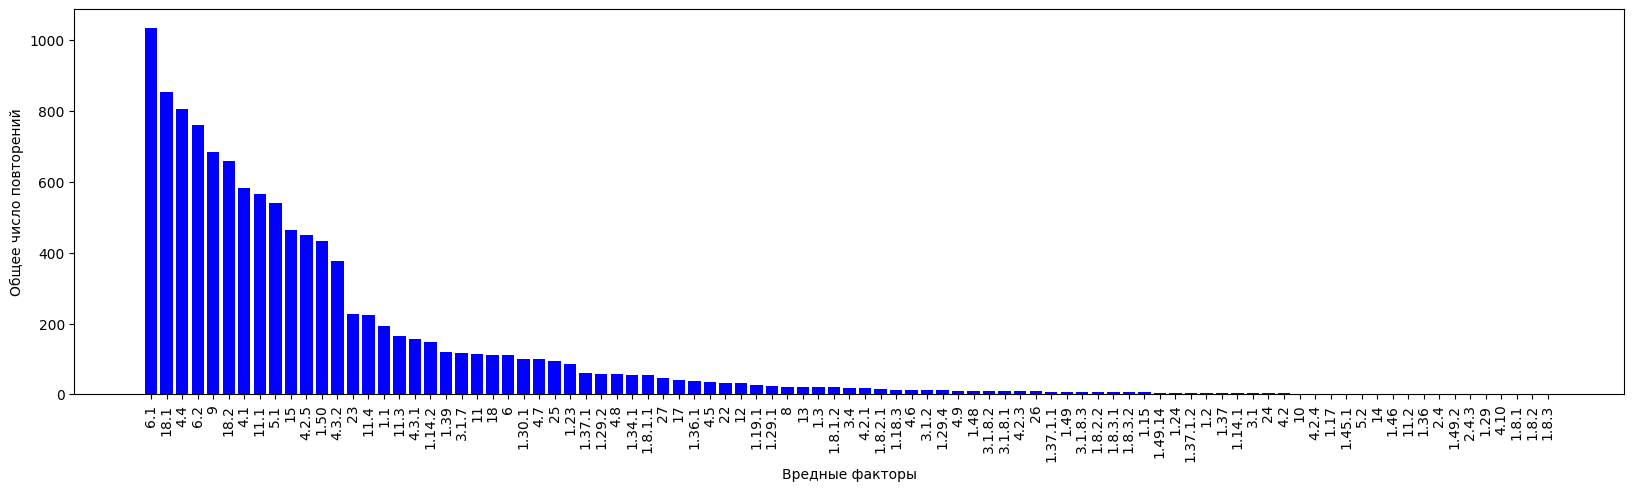

In [ ]:
# Отобразим на столбчатую диаграмму - чачтоту использования наших признаков
plt.figure(figsize=(20, 5))
plt.bar(u_hf_sort_dict.keys(), u_hf_sort_dict.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel('Вредные факторы')
plt.ylabel('Общее число повторений')
plt.gca().set_facecolor('white')
plt.show()

In [ ]:
# Формируем список уникальных значений вредных факторов
# из наиболее часто встречающихся -> оставим первые 15
u_hf_lst = list(u_hf_sort_dict.keys())[:15]
del u_hf_dict
del u_hf_sort_dict

print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

15: u_hf_lst: ['6.1', '18.1', '4.4', '6.2', '9', '18.2', '4.1', '11.1', '5.1', '15', '4.2.5', '1.50', '4.3.2', '23', '11.4']


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
hf_mhe_lst = list()

# число классов
harmful_factors_class_count = len(u_hf_lst) + 1
# то есть по умолчанию выбираем индекс вредного фактора, которого нет в списке
# наших выбранных и ограниченных уникальных вредных факторов
nan_inx = len(u_hf_lst)

# print(f'{len(col_lst)}: col_lst: {col_lst}')
# print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')
# print(f'harmful_factors_class_count: {harmful_factors_class_count}')
# print(f'nan_inx: {nan_inx}')

# пробегаемся по всем строкам колонки
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # устанавливаем все признаки в нули
  i_mhe_lst = [0] * harmful_factors_class_count
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          # проверяем, есть ли этот элемент в списке
          if elem1_lst in u_hf_lst:
            inx = u_hf_lst.index(elem1_lst)
            i_mhe_lst[inx] = 1
          else:
            i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1
  else:
    i_mhe_lst[nan_inx] = 1

  # print(f'  {len(i_mhe_lst)}: {i_mhe_lst}')
  hf_mhe_lst.append(i_mhe_lst)

# print(f'{len(hf_mhe_lst)}: hf_mhe_lst: {hf_mhe_lst}')

# добавляем новую колонку 'ВредныеФакторы' в 'df2'
df2 = df2.assign(ВредныеФакторы=hf_mhe_lst)

del hf_mhe_lst

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 7)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


## МКБ

In [ ]:
def getColNamesByFragmentName(str):
  '''
    Возвращает список названий колонок, в которых содержится заданная строка
    вход:
        str - часть названия колонки, например мкб
    выход:
        retVal - список названий колонок, содержащих заданную строку
  '''
  totalCols = list(df1.columns)
  retVal = [col for col in totalCols if str in col]
  return retVal

In [ ]:
# Находим все колонки, в которых присутсвует часть названия '_МКБ'
fragment_str = '_МКБ'
mkb_cols = getColNamesByFragmentName(fragment_str)
print(f'Число колонок, содержащих "{fragment_str}": {len(mkb_cols)}')

Число колонок, содержащих "_МКБ": 92


In [ ]:
# Формируем список уникальных значений мкб
# MKB Factors
u_mkb_lst = list()

for mkb_col in mkb_cols:
  col_inx = df1.columns.get_loc(mkb_col)
  col_lst = df1.iloc[:, col_inx].tolist()
  # print(f'df1 число строк: {df1.shape[0]}, mkb_col: {mkb_col}')
  # print(f'  len(col_lst): {len(col_lst)}, {col_lst}')
  # Пробегаем по всем строкам текущей колонки
  for i in range(df1.shape[0]):
    i_elem = col_lst[i]
    # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        #print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
        #расщепляем по запятым
        elem_lst = comma_string_split(i_elem)
        #print(f'  {len(elem_lst)}: {elem_lst}')
        if len(elem_lst) > 0:
          for elem1_lst in elem_lst:
            #print(f'    elem1_lst: {elem1_lst}')
            if len(u_mkb_lst) > 0:
              # проверяем, что этого элемента нет в списке
              flag_lst = elem1_lst in u_mkb_lst
              if not flag_lst:
                u_mkb_lst.append(elem1_lst)
            else:
              u_mkb_lst.append(elem1_lst)

# print(f'{len(u_mkb_lst)}: u_mkb_lst: {u_mkb_lst}')

In [ ]:
# создаем словарь МКБ: ключи - МКБ, значения - число повторений
u_mkb_dict = {}
for i_elem in u_mkb_lst:
  u_mkb_dict[i_elem] = 0

# print(f'{len(u_mkb_dict)}: u_mkb_lst: {u_mkb_dict}')

# пробегаемся по всем строкам колонок и заполняем словарь
for mkb_col in mkb_cols:
  col_inx = df1.columns.get_loc(mkb_col)
  col_lst = df1.iloc[:, col_inx].tolist()
  for i in range(df1.shape[0]):
    i_elem = col_lst[i]
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        #расщепляем по запятым
        elem_lst = comma_string_split(i_elem)
        if len(elem_lst) > 0:
          for elem1_lst in elem_lst:
            u_mkb_dict[elem1_lst] += 1

# print(f'{len(u_mkb_dict)}: u_mkb_lst: {u_mkb_dict}')

# сортируем словарь по убыванию
u_mkb_sort_dict = dict(sorted(u_mkb_dict.items(), key=lambda x: x[1], reverse=True))

# print(f'{len(u_mkb_sort_dict)}: u_mkb_sort_dict: {u_mkb_sort_dict}')

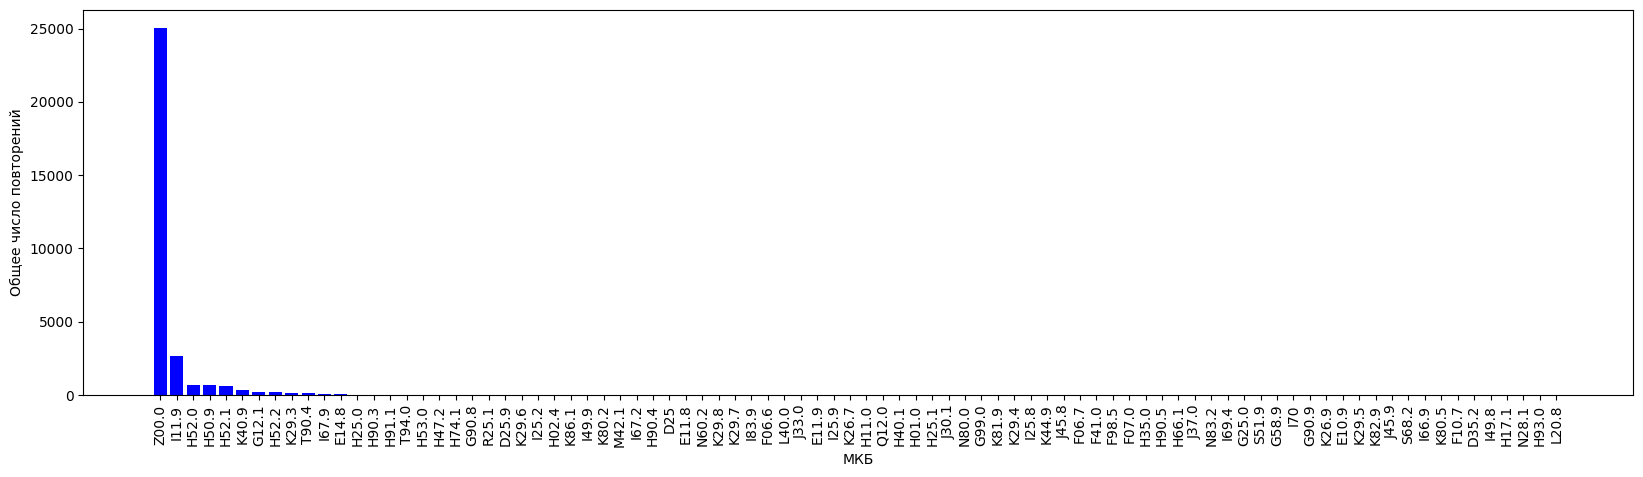

In [ ]:
# Отобразим на столбчатую диаграмму - чачтоту использования наших признаков
plt.figure(figsize=(20, 5))
plt.bar(u_mkb_sort_dict.keys(), u_mkb_sort_dict.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel('МКБ')
plt.ylabel('Общее число повторений')
plt.gca().set_facecolor('white')
plt.show()

In [ ]:
# Формируем список уникальных значений МКБ
# из наиболее часто встречающихся -> оставим первые 3
u_mkb_lst = list(u_mkb_sort_dict.keys())[:3]
del u_mkb_dict
del u_mkb_sort_dict

print(f'{len(u_mkb_lst)}: u_mkb_lst: {u_mkb_lst}')

3: u_mkb_lst: ['Z00.0', 'I11.9', 'H52.0']


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
mkb_mhe_lst = list()

# число классов
mkb_class_count = len(u_mkb_lst) + 1
# то есть по умолчанию выбираем индекс мкб, которого нет в списке
# наших выбранных и ограниченных мкб факторов
nan_inx = len(u_mkb_lst)

for i in range(df1.shape[0]):
  # устанавливаем все признаки в нули
  i_mhe_lst = [0] * mkb_class_count
  mkb_mhe_lst.append(i_mhe_lst)

# print(f'{len(u_mkb_lst)}: u_mkb_lst: {u_mkb_lst}')
# print(f'mkb_class_count: {mkb_class_count}')
# print(f'nan_inx: {nan_inx}')
# print(f'{len(mkb_mhe_lst)}: mkb_mhe_lst: {mkb_mhe_lst}')

# пробегаемся по всем строкам колонок и заполняем словарь
for mkb_col in mkb_cols:
  col_inx = df1.columns.get_loc(mkb_col)
  col_lst = df1.iloc[:, col_inx].tolist()
  # пробегаемся по всем строкам колонки
  for i in range(df1.shape[0]):
    i_elem = col_lst[i]
    # print(f'mkb_col: {mkb_col}: {i}->{df1.shape[0]}: i_elem: {i_elem}')
    # считываем все признаки
    i_mhe_lst = mkb_mhe_lst[i]
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        #расщепляем по запятым
        elem_lst = comma_string_split(i_elem)
        if len(elem_lst) > 0:
          for elem1_lst in elem_lst:
            # проверяем, есть ли этот элемент в списке
            if elem1_lst in u_mkb_lst:
              inx = u_mkb_lst.index(elem1_lst)
              i_mhe_lst[inx] = 1
            else:
              i_mhe_lst[nan_inx] = 1
        else:
          i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1

  # print(f'  {len(i_mhe_lst)}: {i_mhe_lst}')
  mkb_mhe_lst[i] = i_mhe_lst

# print(f'{len(mkb_mhe_lst)}: mkb_mhe_lst: {mkb_mhe_lst}')

# добавляем новую колонку 'МКБ' в 'df2'
df2 = df2.assign(МКБ=mkb_mhe_lst)

del mkb_mhe_lst

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 8)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]"


## ГоденНегоден

In [ ]:
# Создаем гендерный массив, для обработки колонки Гинекология
# 0 - Женский, 1 - Мужской

nan_lst = df1[df1['КлиентПол'].isnull()].index
print(f'"КлиентПол": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['КлиентПол'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

col_inx = df1.columns.get_loc('КлиентПол')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'{len(col_lst)}: {col_lst}')

gender_arr = np.zeros(df1.shape[0], dtype=int)
for i in range(df1.shape[0]):
  gender_arr[i] = getGenderCategory(col_lst[i])

# print(f'{len(col_lst)}: {col_lst}')
print(f'gender_arr: {gender_arr.shape}')
# print(f'{len(gender_arr)}: {gender_arr}')

"КлиентПол": число строк с пустыми значениями: 0
2: ['Женский', 'Мужской']
gender_arr: (3014,)


In [ ]:
# Находим все колонки, в которых присутсвует часть названия '_ГоденНегоден'
# Хирургия1_ГоденНегоден_Значение: 4->4457: i_elem: 072d79e3-1cc0-11e8-80c9-0cc47aab8067
# fuf_col: Гинекология1_ГоденНегоден_ЗначениеПредставление: 16->4457: i_elem: Годен
# fuf_col: Гинекология1_ГоденНегоден_ЗначениеПредставление: 17->4457: i_elem: Не годен
#
# ПОЭТОМУ БУДЕМ ИСПОЛЬЗОВАТЬ КОЛОНКУ `_ГоденНегоден_ЗначениеПредставление`,
# В КОЛОНКЕ `_ГоденНегоден_Значение` ЗАШИФРОВАННЫЕ ЗНАЧЕНИЯ

fragment_str = '_ГоденНегоден_ЗначениеПредставление'
# fit unfit
fuf_cols = getColNamesByFragmentName(fragment_str)
# Сортируем список
fuf_cols.sort()

print(f'Число колонок, содержащих "{fragment_str}": {len(fuf_cols)}')
print('-'*50)
for i in range(len(fuf_cols)):
  print(f'{i}: {fuf_cols[i]}')

Число колонок, содержащих "_ГоденНегоден_ЗначениеПредставление": 31
--------------------------------------------------
0: Гинекология1_ГоденНегоден_ЗначениеПредставление
1: Гинекология2_ГоденНегоден_ЗначениеПредставление
2: Гинекология3_ГоденНегоден_ЗначениеПредставление
3: Гинекология4_ГоденНегоден_ЗначениеПредставление
4: Дерматовенерология1_ГоденНегоден_ЗначениеПредставление
5: Дерматовенерология2_ГоденНегоден_ЗначениеПредставление
6: Неврология1_ГоденНегоден_ЗначениеПредставление
7: Неврология2_ГоденНегоден_ЗначениеПредставление
8: Оториноларингология1_ГоденНегоден_ЗначениеПредставление
9: Оториноларингология2_ГоденНегоден_ЗначениеПредставление
10: Оториноларингология3_ГоденНегоден_ЗначениеПредставление
11: Офтальмология1_ГоденНегоден_ЗначениеПредставление
12: Офтальмология2_ГоденНегоден_ЗначениеПредставление
13: Психиатрия1_ГоденНегоден_ЗначениеПредставление
14: Психиатрия2_ГоденНегоден_ЗначениеПредставление
15: Психиатрия3_ГоденНегоден_ЗначениеПредставление
16: Психиатрия4_ГоденН

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Объединение врач1,врач2,врач3,врач4 в одну колонку
# fit unfit
#~~~~~~~~~~~~~~~~~~~~~~~~
def fuf1234_merge(col_names_lst):
  '''
    Объединение врач1,врач2,врач3,врач4 в одну колонку
    вход:
        colNames1234: список названий колонок для объединения
        df1234: dataframe
    выход:
        retVal: массив 0 - не годен, 1 - ограниченно годен, 2 - годен
  '''
  retVal = np.ones(df1.shape[0], dtype=int)

  # print(f'df1 число строк : {df1.shape[0]}')
  # print(f'df1 число столбцов : {df1.shape[1]}')
  # print(f'{len(col_names_lst)} : {col_names_lst}')
  # print(f'retVal: {retVal.shape}')
  # print(f'{len(retVal)} : {retVal}')

  for j in range(len(col_names_lst)):
    # print(f'{j}: {col_names_lst[j]}')
    col_inx = df1.columns.get_loc(col_names_lst[j])
    col_lst = df1.iloc[:, col_inx].tolist()
    # u_ls = df1[col_names_lst[j]].unique().tolist()
    # print(f'{len(col_lst)}: {u_ls}')
    # print(f'{len(col_lst)}: {col_lst}')
    # пробегаемся по всем строкам колонки
    for i in range(df1.shape[0]):
      i_elem = col_lst[i]
      # print(f'{col_names_lst[j]}: {i}->{df1.shape[0]}: i_elem: {i_elem}')
      # проверяем на nan
      if (i_elem == i_elem):
        # проверяем, что строка не пустая
        if i_elem:
          ui_elem = i_elem.lower()
          # print(f'{col_names_lst[j]}: {i}->{df1.shape[0]}: i_elem: {i_elem}, ui_elem: {ui_elem}')
          # 0 - не годен, 1 - ограниченно годен, 2 - годен
          if 'не годен' == ui_elem:
            retVal[i] = 0
          elif 'годен' == ui_elem:
            if 1 == retVal[i]:
              retVal[i] = 2

  return retVal

In [ ]:
#~~~ 0
# 0: Гинекология1_ГоденНегоден_ЗначениеПредставление
# 1: Гинекология2_ГоденНегоден_ЗначениеПредставление
# 2: Гинекология3_ГоденНегоден_ЗначениеПредставление
# 3: Гинекология4_ГоденНегоден_ЗначениеПредставление
fuf_lst = list()
fuf_lst.append(fuf_cols[0])
fuf_lst.append(fuf_cols[1])
fuf_lst.append(fuf_cols[2])
fuf_lst.append(fuf_cols[3])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)

# print(f'{len(fuf_arr)}: {fuf_arr}')
# print(f'{gender_arr.shape}: {gender_arr}')

# пробегаемся по всем строкам колонки
# исправляем по гендерному признаку: мужчина по определению годен
for i in range(df1.shape[0]):
  if 1 == gender_arr[i]:
    fuf_arr[i] = 2

# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ГинекологияГНГ' в 'df2'
df2 = df2.assign(ГинекологияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

4: ['Гинекология1_ГоденНегоден_ЗначениеПредставление', 'Гинекология2_ГоденНегоден_ЗначениеПредставление', 'Гинекология3_ГоденНегоден_ЗначениеПредставление', 'Гинекология4_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 9)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]"


In [ ]:
#~~~ 1
# 4: Дерматовенерология1_ГоденНегоден_ЗначениеПредставление
# 5: Дерматовенерология2_ГоденНегоден_ЗначениеПредставление
fuf_lst.clear()
fuf_lst.append(fuf_cols[4])
fuf_lst.append(fuf_cols[5])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)
# print(f'{len(fuf_arr)}: {fuf_arr}')
# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ДерматовенерологияГНГ' в 'df2'
df2 = df2.assign(ДерматовенерологияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

2: ['Дерматовенерология1_ГоденНегоден_ЗначениеПредставление', 'Дерматовенерология2_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 10)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]"


In [ ]:
#~~~ 2
# 6: Неврология1_ГоденНегоден_ЗначениеПредставление
# 7: Неврология2_ГоденНегоден_ЗначениеПредставление
fuf_lst.clear()
fuf_lst.append(fuf_cols[6])
fuf_lst.append(fuf_cols[7])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)
# print(f'{len(fuf_arr)}: {fuf_arr}')
# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'НеврологияГНГ' в 'df2'
df2 = df2.assign(НеврологияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

2: ['Неврология1_ГоденНегоден_ЗначениеПредставление', 'Неврология2_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 11)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]"


In [ ]:
#~~~ 3
# 8: Оториноларингология1_ГоденНегоден_ЗначениеПредставление
# 9: Оториноларингология2_ГоденНегоден_ЗначениеПредставление
# 10: Оториноларингология3_ГоденНегоден_ЗначениеПредставление
fuf_lst.clear()
fuf_lst.append(fuf_cols[8])
fuf_lst.append(fuf_cols[9])
fuf_lst.append(fuf_cols[10])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)
# print(f'{len(fuf_arr)}: {fuf_arr}')
# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ОториноларингологияГНГ' в 'df2'
df2 = df2.assign(ОториноларингологияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

3: ['Оториноларингология1_ГоденНегоден_ЗначениеПредставление', 'Оториноларингология2_ГоденНегоден_ЗначениеПредставление', 'Оториноларингология3_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 12)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]"


In [ ]:
#~~~ 4
# 11: Офтальмология1_ГоденНегоден_ЗначениеПредставление
# 12: Офтальмология2_ГоденНегоден_ЗначениеПредставление
fuf_lst.clear()
fuf_lst.append(fuf_cols[11])
fuf_lst.append(fuf_cols[12])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)
# print(f'{len(fuf_arr)}: {fuf_arr}')
# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ОфтальмологияГНГ' в 'df2'
df2 = df2.assign(ОфтальмологияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

2: ['Офтальмология1_ГоденНегоден_ЗначениеПредставление', 'Офтальмология2_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 13)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ,ОфтальмологияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]"


In [ ]:
#~~~ 5
# 13: Психиатрия1_ГоденНегоден_ЗначениеПредставление
# 14: Психиатрия2_ГоденНегоден_ЗначениеПредставление
# 15: Психиатрия3_ГоденНегоден_ЗначениеПредставление
# 16: Психиатрия4_ГоденНегоден_ЗначениеПредставление
fuf_lst.clear()
fuf_lst.append(fuf_cols[13])
fuf_lst.append(fuf_cols[14])
fuf_lst.append(fuf_cols[15])
fuf_lst.append(fuf_cols[16])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)
# print(f'{len(fuf_arr)}: {fuf_arr}')
# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ПсихиатрияГНГ' в 'df2'
df2 = df2.assign(ПсихиатрияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

4: ['Психиатрия1_ГоденНегоден_ЗначениеПредставление', 'Психиатрия2_ГоденНегоден_ЗначениеПредставление', 'Психиатрия3_ГоденНегоден_ЗначениеПредставление', 'Психиатрия4_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 14)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]"


In [ ]:
#~~~ 6
# 17: ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление
# 18: ПсихиатрияНаркология2_ГоденНегоден_ЗначениеПредставление
fuf_lst.clear()
fuf_lst.append(fuf_cols[17])
fuf_lst.append(fuf_cols[18])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)
# print(f'{len(fuf_arr)}: {fuf_arr}')
# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ПсихиатрияНаркологияГНГ' в 'df2'
df2 = df2.assign(ПсихиатрияНаркологияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

2: ['ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление', 'ПсихиатрияНаркология2_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 15)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]"


In [ ]:
#~~~ 7
# 19: Стоматология1_ГоденНегоден_ЗначениеПредставление
# 20: Стоматология2_ГоденНегоден_ЗначениеПредставление
fuf_lst.clear()
fuf_lst.append(fuf_cols[19])
fuf_lst.append(fuf_cols[20])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)
# print(f'{len(fuf_arr)}: {fuf_arr}')
# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'СтоматологияГНГ' в 'df2'
df2 = df2.assign(СтоматологияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

2: ['Стоматология1_ГоденНегоден_ЗначениеПредставление', 'Стоматология2_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 16)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ,СтоматологияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]"


In [ ]:
#~~~ 8
# 21: ТерапевтНеИсп1_ГоденНегоден_ЗначениеПредставление
# col_inx = df1.columns.get_loc(fuf_cols[21])
# u_ls = df1[fuf_cols[21]].unique().tolist()
# col_lst = df1.iloc[:, col_inx].tolist()

# print(f'{fuf_cols[21]}:')
# print(f'{len(u_ls)}: {u_ls}')
# print(f'{len(col_lst)}: {col_lst}')

# ТерапевтНеИсп1_ГоденНегоден_ЗначениеПредставление:
# 2: [nan, 'Годен']


# ->ТерапевтНеИсп не использую эту колонку

In [ ]:
#~~~ 9
# 22: Терапия1_ГоденНегоден_ЗначениеПредставление
# 23: Терапия2_ГоденНегоден_ЗначениеПредставление
# 24: Терапия3_ГоденНегоден_ЗначениеПредставление
# 25: Терапия4_ГоденНегоден_ЗначениеПредставление
fuf_lst.clear()
fuf_lst.append(fuf_cols[22])
fuf_lst.append(fuf_cols[23])
fuf_lst.append(fuf_cols[24])
fuf_lst.append(fuf_cols[25])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)
# print(f'{len(fuf_arr)}: {fuf_arr}')
# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ТерапияГНГ' в 'df2'
df2 = df2.assign(ТерапияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

4: ['Терапия1_ГоденНегоден_ЗначениеПредставление', 'Терапия2_ГоденНегоден_ЗначениеПредставление', 'Терапия3_ГоденНегоден_ЗначениеПредставление', 'Терапия4_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 17)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ,СтоматологияГНГ,ТерапияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]"


In [ ]:
#~~~ 10
# 26: ХирургНеИсп1_ГоденНегоден_ЗначениеПредставление
# 27: ХирургНеИсп2_ГоденНегоден_ЗначениеПредставление

# ->ХирургНеИсп не использую эту колонку

In [ ]:
#~~~ 11
# 28: Хирургия1_ГоденНегоден_ЗначениеПредставление
# 29: Хирургия2_ГоденНегоден_ЗначениеПредставление
# 30: Хирургия3_ГоденНегоден_ЗначениеПредставление
fuf_lst.clear()
fuf_lst.append(fuf_cols[28])
fuf_lst.append(fuf_cols[29])
fuf_lst.append(fuf_cols[30])
print(f'{len(fuf_lst)}: {fuf_lst}')

fuf_arr = fuf1234_merge(fuf_lst)
# print(f'{len(fuf_arr)}: {fuf_arr}')
# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(fuf_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ХирургияГНГ' в 'df2'
df2 = df2.assign(ХирургияГНГ=ohe_lst2)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

3: ['Хирургия1_ГоденНегоден_ЗначениеПредставление', 'Хирургия2_ГоденНегоден_ЗначениеПредставление', 'Хирургия3_ГоденНегоден_ЗначениеПредставление']
размеры датафрейма: df1: (3014, 4588), df2: (3014, 18)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ,СтоматологияГНГ,ТерапияГНГ,ХирургияГНГ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]"


In [ ]:
del gender_arr
del fuf_cols
del fuf_lst
del fuf_arr

# Числовые признаки

## Определяем числовые колонки

In [ ]:
float_cols = list(df1.select_dtypes(include=['float64']).columns)
float_cols_count = len(float_cols)

print(f'Колоноки типа float: {float_cols_count}')
# for i in range(float_cols_count):
#   print(f'{i}: {float_cols[i]}')

Колоноки типа float: 1253


## Артериальное давление

In [ ]:
# Находим все колонки, в которых присутсвует часть названия '_Артер'(АртериальноеДавление)
fragment_str = '_Артер'
# Arterial pressure
digit_cols = getColNamesByFragmentName(fragment_str)
print(f'Число колонок, содержащих "{fragment_str}": {len(digit_cols)}')

Число колонок, содержащих "_Артер": 20


In [ ]:
# # пробегаемся по всем строкам колонок и заполняем словарь
# for dig_col in digit_cols:
#   col_inx = df1.columns.get_loc(dig_col)
#   col_lst = df1.iloc[:, col_inx].tolist()

#   # print(f'dig_col: {dig_col}')
#   # print(f'  len(col_lst): {len(col_lst)}: col_lst: {col_lst}')

#   # Терапия1_АртериальноеДавление_Значение
#   #   len(col_lst): 1571: col_lst: ['140/100', '150/100', '120/80', '120\\80', '110/70', '110/70', '105/70', '120/70', '140/80', '120/80', '120\\80', '130\\80', '125/85', '130\\80', '120\\80', '133', '120', '100', '120', '110',

#   # dig_col: Терапия1_АртериальноеДавление21_Значение
#   #   len(col_lst): 1571: col_lst: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 82.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 60.0, 80.0, 70.0, 90.0, 110.0, nan, 70.0, 80.0, 120.0, 70.

#    # 2023.06.02. выбираю колонку Терапия1_АртериальноеДавление21_Значение

In [ ]:
# Колонка Терапия1_АртериальноеДавление21_Значение
nan_lst = df1[df1['Терапия1_АртериальноеДавление21_Значение'].isnull()].index
nan_lst_count_proc = len(nan_lst)*100/df2.size
print(f'df1 число строк: {df1.shape[0]}')
print(f'"Терапия1_АртериальноеДавление21_Значение": число строк с пустыми значениями: {len(nan_lst)}, {round(nan_lst_count_proc, 2)}%')

min_val = df1['Терапия1_АртериальноеДавление21_Значение'].min()
max_val = df1['Терапия1_АртериальноеДавление21_Значение'].max()
mean_val = df1['Терапия1_АртериальноеДавление21_Значение'].mean()
print(f'Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

df1 число строк: 3014
"Терапия1_АртериальноеДавление21_Значение": число строк с пустыми значениями: 567, 1.05%
Значения: min: 20.0, max: 805.0, mean: 82.59


In [ ]:
# Находим минимальное максимальное значения, пустые значения заполняем средним
f_arr = df1['Терапия1_АртериальноеДавление21_Значение'].values.astype('float64')

# f_indices = []
# for i in range(len(f_arr)):
#   if f_arr[i] > 200.0:
#     f_indices.append(i)
# print(f_indices)
# print(f'f_indices[0]: {f_indices[0]}:, {f_arr[f_indices[0]]}')
# print(f'f_indices[1]: {f_indices[1]}:, {f_arr[f_indices[1]]}')
# del f_indices

f_arr_lst = list()
for i in range(len(f_arr)):
  # print(f'{i}: {f_arr[i]}')
  # проверяем на nan
  if (f_arr[i] == f_arr[i]):
    f_arr_lst.append(f_arr[i])

f_arr2 = np.array(f_arr_lst, dtype=np.float64)

# print(f'len(f_arr_lst): {len(f_arr_lst)}:, {f_arr_lst}')
# print(f'len(f_arr2): {len(f_arr2)}:, {f_arr2}')

del f_arr_lst

min_val = np.min(f_arr2)
max_val = np.max(f_arr2)
mean_val = np.mean(f_arr2)
print(f'{f_arr2.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

for i in range(len(f_arr2)):
  if f_arr2[i] > 200.0:
    f_arr2[i] /= 10.0

min_val = np.min(f_arr2)
max_val = np.max(f_arr2)
mean_val = np.mean(f_arr2)
print(f'{f_arr2.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

# Заполняем пустые ячейки и убираем выбросы
for i in range(len(f_arr)):
  # проверяем на nan
  if (f_arr[i] == f_arr[i]):
    if f_arr[i] > 200.0:
      f_arr[i] /= 10.0
  else:
    f_arr[i] = mean_val

del f_arr2

min_val = np.min(f_arr)
max_val = np.max(f_arr)
mean_val = np.mean(f_arr)
max_min_delta = max_val - min_val
print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}, max_min_delta: {round(max_min_delta, 2)}')

# Проведем min-max нормирвоание
for i in range(len(f_arr)):
  f_arr[i] = (f_arr[i] - min_val)/max_min_delta

min_val = np.min(f_arr)
max_val = np.max(f_arr)
mean_val = np.mean(f_arr)
print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

(2447,): Значения: min: 20.0, max: 805.0, mean: 82.59
(2447,): Значения: min: 20.0, max: 120.0, mean: 82.0
(3014,): Значения: min: 20.0, max: 120.0, mean: 82.0, max_min_delta: 100.0
(3014,): Значения: min: 0.0, max: 1.0, mean: 0.62


In [ ]:
# добавляем новую колонку 'АртДавление'('АртериальноеДавление') в 'df2'
df2 = df2.assign(АртДавление=f_arr)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 19)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ,СтоматологияГНГ,ТерапияГНГ,ХирургияГНГ,АртДавление
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]",0.61999
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]",0.61999
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]",0.61999


## ИМТ - индекс массы тела

In [ ]:
# Находим все колонки, в которых присутсвует часть названия '_Артер'(АртериальноеДавление)
fragment_str = '_ИМТ'
# Arterial pressure
digit_cols = getColNamesByFragmentName(fragment_str)
print(f'Число колонок, содержащих "{fragment_str}": {len(digit_cols)}')

Число колонок, содержащих "_ИМТ": 10


In [ ]:
# # пробегаемся по всем строкам колонок и заполняем словарь
# for dig_col in digit_cols:
#   col_inx = df1.columns.get_loc(dig_col)
#   col_lst = df1.iloc[:, col_inx].tolist()

#   print(f'dig_col: {dig_col}')
#   print(f'  len(col_lst): {len(col_lst)}: col_lst: {col_lst}')

# Терапия1_ИМТ_Значение
# len(col_lst): 1571: col_lst: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, '22.53', '29.74', '19.92', '29.37', '23.24', '2.52', '30.08'
# Терапия1_ИМТ_ЗначениеПредставление
# len(col_lst): 1571: col_lst: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 22.53, 29.74, 19.92, 29.37, 23.24, 2.52, 30.08, 24.06, 30.12, 23.92,

In [ ]:
# df1['Терапия1_ИМТ_Значение'].dtype
# dtype('O')

# df1['Терапия1_ИМТ_ЗначениеПредставление'].dtype
# dtype('float64')

In [ ]:
# Колонка Терапия1_ИМТ_ЗначениеПредставление
nan_lst = df1[df1['Терапия1_ИМТ_ЗначениеПредставление'].isnull()].index
nan_lst_count_proc = len(nan_lst)*100/df2.size
print(f'df1 число строк: {df1.shape[0]}')
print(f'"Терапия1_ИМТ_ЗначениеПредставление": число строк с пустыми значениями: {len(nan_lst)}, {round(nan_lst_count_proc, 2)}%')

min_val = df1['Терапия1_ИМТ_ЗначениеПредставление'].min()
max_val = df1['Терапия1_ИМТ_ЗначениеПредставление'].max()
mean_val = df1['Терапия1_ИМТ_ЗначениеПредставление'].mean()
print(f'Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

df1 число строк: 3014
"Терапия1_ИМТ_ЗначениеПредставление": число строк с пустыми значениями: 632, 1.1%
Значения: min: 0.19, max: 49.38, mean: 27.16


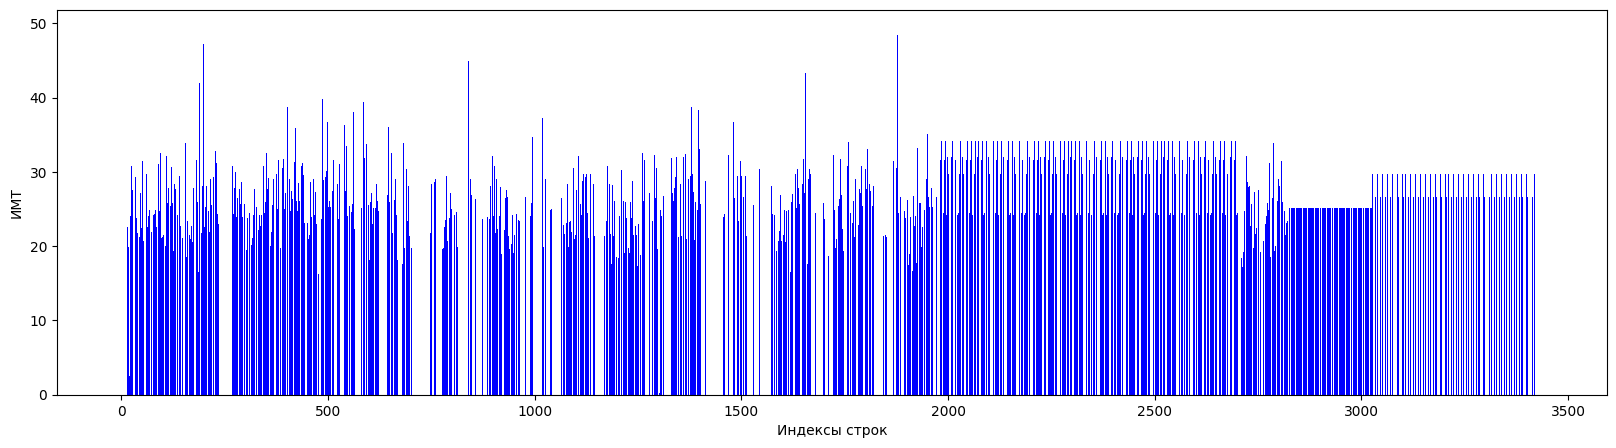

In [ ]:
plt.figure(figsize=(20, 5))
plt.bar(df1.index, df1['Терапия1_ИМТ_ЗначениеПредставление'], color='blue')
#plt.xticks(rotation=90)
plt.xlabel('Индексы строк')
plt.ylabel('ИМТ')
#plt.gca().set_facecolor('white')
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

In [ ]:
# Находим минимальное максимальное значения, пустые значения заполняем средним
f_arr = df1['Терапия1_ИМТ_ЗначениеПредставление'].values.astype('float64')

f_arr_lst = list()
for i in range(len(f_arr)):
  # проверяем на nan
  if (f_arr[i] == f_arr[i]):
    f_arr_lst.append(f_arr[i])
f_arr2 = np.array(f_arr_lst, dtype=np.float64)
del f_arr_lst

min_val = np.min(f_arr2)
max_val = np.max(f_arr2)
mean_val = np.mean(f_arr2)
print(f'{f_arr2.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

# Заполняем пустые ячейки и убираем выбросы
for i in range(len(f_arr)):
  # проверяем на nan
  if not (f_arr[i] == f_arr[i]):
    f_arr[i] = mean_val
del f_arr2

min_val = np.min(f_arr)
max_val = np.max(f_arr)
mean_val = np.mean(f_arr)
max_min_delta = max_val - min_val
print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}, max_min_delta: {round(max_min_delta, 2)}')

# Проведем min-max нормирвоание
for i in range(len(f_arr)):
  f_arr[i] = (f_arr[i] - min_val)/max_min_delta

min_val = np.min(f_arr)
max_val = np.max(f_arr)
mean_val = np.mean(f_arr)
print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

(2382,): Значения: min: 0.19, max: 49.38, mean: 27.16
(3014,): Значения: min: 0.19, max: 49.38, mean: 27.16, max_min_delta: 49.19
(3014,): Значения: min: 0.0, max: 1.0, mean: 0.55


In [ ]:
# добавляем новую колонку 'ИМТ' в 'df2'
df2 = df2.assign(ИМТ=f_arr)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 20)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ,СтоматологияГНГ,ТерапияГНГ,ХирургияГНГ,АртДавление,ИМТ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]",0.61999,0.548234
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]",0.61999,0.548234
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]",0.61999,0.548234


# Текстовые признаки (Цех+Профессия: Tokenizer-Bag of Words)

считаю, что цех и профессию необходимо объединить в один признак

In [ ]:
print(f'размеры датафрейма: df1: {df1.shape}')
nan_lst = df1[df1['Цех'].isnull()].index
print(f'"Цех": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Цех'].unique().tolist()
# print(f'уникальные значения: {len(u_lst)}: {u_lst}')
print(f'уникальные значения: {len(u_lst)}')

размеры датафрейма: df1: (3014, 4588)
"Цех": число строк с пустыми значениями: 1491
уникальные значения: 173


In [ ]:
print(f'размеры датафрейма: df1: {df1.shape}')
nan_lst = df1[df1['Профессия'].isnull()].index
print(f'"Профессия": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Профессия'].unique().tolist()
# print(f'уникальные значения: {len(u_lst)}: {u_lst}')
print(f'уникальные значения: {len(u_lst)}')

размеры датафрейма: df1: (3014, 4588)
"Профессия": число строк с пустыми значениями: 0
уникальные значения: 557


In [ ]:
# branch + profession
# результирующий список
brh_prn_lst = [""] * df1.shape[0]
# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Цех
col_inx = df1.columns.get_loc('Цех')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] = i_elem2
    else:
      brh_prn_lst[i] = 'без отдела'
  else:
    brh_prn_lst[i] = 'без отдела'

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Профессия
col_inx = df1.columns.get_loc('Профессия')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] += ' ' + i_elem2

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}')
# пример цех+профессия 123-ей записи-строки
print(brh_prn_lst[123])

df1 число строк: 3014, len(brh_prn_lst): 3014
без отдела слесарь по ремонту автомобилей 6 разряда


In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

#определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# maxWordsCount = 10000
# число строк: 3014, len(brh_prn_items): 765, [('unknown', 1), ('отдела', 2), ('без', 3), ('разряда', 4), ('водитель', 5), ('автомобиля', 6), ('по', 7), ('слесарь', 8), ('6', 9)
maxWordsCount = 765

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

# "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
tokenizer.fit_on_texts(brh_prn_lst)

#Вытаскиваем индексы слов для просмотра
brh_prn_items = list(tokenizer.word_index.items())
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_items): {len(brh_prn_items)}, {brh_prn_items}')

df1 число строк: 3014, len(brh_prn_items): 765, [('unknown', 1), ('отдела', 2), ('без', 3), ('разряда', 4), ('водитель', 5), ('автомобиля', 6), ('по', 7), ('слесарь', 8), ('6', 9), ('инженер', 10), ('приволжский', 11), ('филиал', 12), ('фгуп', 13), ('радон', 14), ('благовещенское', 15), ('отделение', 16), ('ремонту', 17), ('отдел', 18), ('5', 19), ('автомобилей', 20), ('и', 21), ('специалист', 22), ('участок', 23), ('машинист', 24), ('ведущий', 25), ('работ', 26), ('монтажник', 27), ('технологических', 28), ('механосборочных', 29), ('трубопроводов', 30), ('электромонтер', 31), ('переработчик', 32), ('рао', 33), ('лаборант', 34), ('кабаковский', 35), ('5510', 36), ('анализа', 37), ('плотник', 38), ('спектр', 39), ('копра', 40), ('угмк', 41), ('категории', 42), ('старший', 43), ('начальник', 44), ('агроном', 45), ('межрайонный', 46), ('уфа', 47), ('главный', 48), ('1', 49), ('обслуживанию', 50), ('менеджер', 51), ('проектировщик', 52), ('охранник', 53), ('вс', 54), ('с', 55), ('продавец'

In [ ]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
#обучающие тесты в индексы
brh_prn_inxs = tokenizer.texts_to_sequences(brh_prn_lst)
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_inxs): {len(brh_prn_inxs)}, {brh_prn_inxs}')

df1 число строк: 3014, len(brh_prn_inxs): 3014, [[3, 2, 25, 22, 7, 341, 535], [3, 2, 25, 22], [3, 2, 48, 51], [18, 342, 21, 227, 297, 64, 48, 22], [18, 185, 119, 21, 84, 65, 64, 43, 22], [3, 2, 43, 22], [18, 185, 119, 21, 84, 65, 64, 44, 2], [18, 185, 119, 21, 84, 65, 64, 48, 22], [18, 185, 119, 21, 84, 65, 64, 48, 22], [3, 2, 43, 22], [3, 2, 43, 10], [3, 2, 48, 22], [18, 342, 21, 227, 297, 64, 48, 22], [18, 342, 21, 227, 297, 64, 43, 10], [3, 2, 25, 10], [3, 2, 22], [18, 298, 26, 21, 266, 299, 43, 22], [18, 298, 26, 21, 266, 299, 22], [18, 228, 21, 229, 230, 48, 22], [18, 228, 21, 229, 230, 48, 22], [18, 228, 21, 229, 230, 25, 22], [18, 228, 21, 229, 230, 25, 22], [18, 228, 21, 229, 230, 48, 22], [3, 2, 128, 54, 58, 4], [3, 2, 85, 80], [3, 2, 85, 80], [3, 2, 128, 153, 204], [3, 2, 128, 153, 204], [3, 2, 128, 153, 204], [3, 2, 128, 153, 204], [3, 2, 128, 54, 58, 4], [3, 2, 128, 54, 58, 4], [3, 2, 128, 153, 204], [3, 2, 43, 85], [3, 2, 128, 153, 204], [3, 2, 80], [3, 2, 128, 153, 204], 

In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
# Подаем xTrain в виде списка чтобы метод успешно сработал
xTrainProf01 = tokenizer.sequences_to_matrix(brh_prn_inxs)
# Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01.shape)
print(f'xTrainProf01 число строк : {xTrainProf01.shape[0]}')
print(f'xTrainProf01 число столбцов : {xTrainProf01.shape[1]}')
print(xTrainProf01[0][0:100])

(3014, 765)
xTrainProf01 число строк : 3014
xTrainProf01 число столбцов : 765
[0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 123
# Цех+Профессия
print(brh_prn_lst[n])
# Профессия через индексы
print(brh_prn_inxs[n])

без отдела слесарь по ремонту автомобилей 6 разряда
[3, 2, 8, 7, 17, 20, 9, 4]


In [ ]:
brh_mhe_lst = xTrainProf01.astype(int).tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(brh_mhe_lst): {len(brh_mhe_lst)}, {brh_mhe_lst}')

# добавляем новую колонку 'ЦехПрофессия' в 'df2'
df2 = df2.assign(ЦехПрофессия=brh_mhe_lst)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (3014, 4588), df2: (3014, 21)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,...,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ,СтоматологияГНГ,ТерапияГНГ,ХирургияГНГ,АртДавление,ИМТ,ЦехПрофессия
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]",...,"[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]",0.61999,0.548234,"[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]",...,"[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]",0.61999,0.548234,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]",...,"[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]",0.61999,0.548234,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
del brh_prn_lst
del brh_prn_inxs
del xTrainProf01
del brh_mhe_lst

# Проверка таблицы на пустые ячейки

In [ ]:
print(f'df2 число строк: {df2.shape[0]}')
print(f'df2 число колонок: {df2.shape[1]}')

nan_cell_count = df2.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df2.size
print(f'общее количество пропусков во всей таблице df2: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

df2 число строк: 3014
df2 число колонок: 21
общее количество пропусков во всей таблице df2: 0, 0.0%


# Перемешиваем все строки датафрейма2, это необходимо сделать особенно после добавления строк


In [ ]:
print(f'размеры датафрейма df2: {df2.shape}')
df2.head(3)

размеры датафрейма df2: (3014, 21)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,...,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ,СтоматологияГНГ,ТерапияГНГ,ХирургияГНГ,АртДавление,ИМТ,ЦехПрофессия
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]",...,"[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]",0.61999,0.548234,"[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 1, 0, 1]","[0, 0, 1]","[0, 0, 1]",...,"[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]",0.61999,0.548234,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 0, 1]",...,"[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]",0.61999,0.548234,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Перемешиваем строки в нашей таблице
df2_shuffle = df2.sample(frac=1).reset_index(drop=True)
print(f'размеры датафрейма df2_shuffle: {df2_shuffle.shape}')
df2_shuffle.head(3)

размеры датафрейма df2_shuffle: (3014, 21)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,...,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ,СтоматологияГНГ,ТерапияГНГ,ХирургияГНГ,АртДавление,ИМТ,ЦехПрофессия
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",0,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]",...,"[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]",0.60,0.422240,"[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1]","[0, 0, 1]","[0, 1, 0]",...,"[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[1, 0, 0]","[0, 1, 0]",0.60,0.759504,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]",...,"[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]",0.56,0.530799,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Обучение Нейросети

## Удаляю первый датафрейм, чтобы освободить память

In [ ]:
#del df1

## Разделяем на отдельные выборки

In [ ]:
# y_data
# преобразуем списки в отдельные колонки
df_y = df2_shuffle['ЗаключениеМКК'].apply(pd.Series)
print(f'размеры датафрейма df4: {df_y.shape}')
# преобразуем в numpy массив типа float
y_data = df_y.astype(float).to_numpy()
print('Количество осей: ', y_data.ndim)
print('Форма массива: ', y_data.shape)
print('Количество значений: ', y_data.size)

размеры датафрейма df4: (3014, 3)
Количество осей:  2
Форма массива:  (3014, 3)
Количество значений:  9042


In [ ]:
# x1_data -> категориальные признаки
df_x1 = df2_shuffle.drop(['ЗаключениеМКК','АртДавление','ИМТ'], axis = 1)
df_x1.head(3)

,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,ГинекологияГНГ,ДерматовенерологияГНГ,НеврологияГНГ,ОториноларингологияГНГ,ОфтальмологияГНГ,ПсихиатрияГНГ,ПсихиатрияНаркологияГНГ,СтоматологияГНГ,ТерапияГНГ,ХирургияГНГ,ЦехПрофессия
0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",0,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[1, 0, 0]","[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1]","[0, 1, 0]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# x2_data -> числовые признаки
df_x2 = df2_shuffle.drop(['ЗаключениеМКК','Возраст','КлиентПол','ТипМедосмотра','ПсихОсвидетельствование','ДиспансернаяГруппа','ВредныеФакторы','МКБ','ГинекологияГНГ','ДерматовенерологияГНГ','НеврологияГНГ','ОториноларингологияГНГ','ОфтальмологияГНГ','ПсихиатрияГНГ','ПсихиатрияНаркологияГНГ','СтоматологияГНГ','ТерапияГНГ','ХирургияГНГ','ЦехПрофессия'], axis = 1)
df_x2.head(3)

,АртДавление,ИМТ
0,0.60,0.422240
1,0.60,0.759504
2,0.56,0.530799


In [ ]:
# Формируем массив x1_data-категориальные
# трансформируем one-hot-encoding списки в отдельные колонки (для df_x1)
split_col_names = list()
split_col_names.append('Возраст')
split_col_names.append('ДиспансернаяГруппа')
split_col_names.append('ВредныеФакторы')
split_col_names.append('МКБ')

split_col_names.append('ГинекологияГНГ')
split_col_names.append('ДерматовенерологияГНГ')
split_col_names.append('НеврологияГНГ')
split_col_names.append('ОториноларингологияГНГ')
split_col_names.append('ОфтальмологияГНГ')
split_col_names.append('ПсихиатрияГНГ')
split_col_names.append('ПсихиатрияНаркологияГНГ')
split_col_names.append('СтоматологияГНГ')
split_col_names.append('ТерапияГНГ')
split_col_names.append('ХирургияГНГ')

split_col_names.append('ЦехПрофессия')

for col_name in split_col_names:
  df_x1 = pd.concat([df_x1.drop(col_name, axis=1), df_x1[col_name].apply(pd.Series)], axis=1)

# преобразуем в numpy массив типа float
x1_data = df_x1.astype(float).to_numpy()
print('Количество осей: ', x1_data.ndim)
print('Форма массива: ', x1_data.shape)
print('Количество значений: ', x1_data.size)

Количество осей:  2
Форма массива:  (3014, 834)
Количество значений:  2513676


In [ ]:
# Формируем массив x2_data-числовые
x2_data = df_x2.astype(float).to_numpy()
print('Количество осей: ', x2_data.ndim)
print('Форма массива: ', x2_data.shape)
print('Количество значений: ', x2_data.size)

Количество осей:  2
Форма массива:  (3014, 2)
Количество значений:  6028


In [ ]:
# del df2

del df2_shuffle
del df_y
del df_x1
del df_x2

## Общие настройки и функции

In [ ]:
# Переменные-настройки-параметры-для-обучения-сети
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 50
VERBOSE = 1
#percent: 0..1
TEST_DATA_SIZE = 0.15
VALID_DATA_SIZE = 0.05

#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'LEARNING_RATE: {LEARNING_RATE}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'EPOCHS: {EPOCHS}')
print(f'VERBOSE: {VERBOSE}')
print(f'TEST_DATA_SIZE: {TEST_DATA_SIZE}')
print(f'VALID_DATA_SIZE: {VALID_DATA_SIZE}')

LEARNING_RATE: 0.001
BATCH_SIZE: 128
EPOCHS: 50
VERBOSE: 1
TEST_DATA_SIZE: 0.15
VALID_DATA_SIZE: 0.05


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Графическое представление результатов работы нейросети
#~~~~~~~~~~~~~~~~~~~~~~~~
def printNNChart(history_n):
  '''
    Отображенние на графике результатов работы нейронной сети (Neural Network)
    вход:
        history_n: массив результатов работы нейросети
  '''
  # Создание полотна для рисунка
  plt.figure(figsize=(18,5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
  plt.plot(history_n.history['loss'],
           color='blue',
           label = 'Значение ошибки на обучающем наборе')
  plt.plot(history_n.history['val_loss'],
           color='red',
           label = 'Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
  plt.plot(history_n.history['accuracy'],
           color='blue',
           label = 'Доля верных ответов на обучающем наборе')
  plt.plot(history_n.history['val_accuracy'],
           color='red',
           label = 'Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Фиксация графиков и рисование всей картинки
  plt.show()

## Нейронка1 - категориальные(текстовые трансформированы в категориальные) признаки

In [ ]:
# Создание обучающей и тестовой выборки
x_train, x_test, y_train, y_test = train_test_split(x1_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=TEST_DATA_SIZE, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость
# Выведем размерность полученных выборок
print('Обучающая выборка параметров', x_train.shape)
print('Обучающая выборка меток классов', y_train.shape)
print()
print('Тестовая выборка параметров', x_test.shape)
print('Тестовая выборка меток классов', y_test.shape)

Обучающая выборка параметров (2561, 834)
Обучающая выборка меток классов (2561, 3)

Тестовая выборка параметров (453, 834)
Тестовая выборка меток классов (453, 3)


In [ ]:
# Создание модели
model1 = Sequential()

# Добавление слоев
model1.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(30))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(10))

model1.add(Dense(3, activation = 'softmax'))

In [ ]:
# Компиляция
model1.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=LEARNING_RATE),
               metrics=['accuracy'])

In [ ]:
# Обучение нейронной сети
history1 = model1.fit(x_train,                             # Обучающая выборка параметров
                      y_train,                             # Обучающая выборка меток класса
                      batch_size=BATCH_SIZE,               # Размер батча (пакета)
                      epochs=EPOCHS,                       # Количество эпох обучения
                      validation_split=VALID_DATA_SIZE,    # Доля проверочной выборки
                      verbose=VERBOSE)                     # Отображение хода обучения

Epoch 1/50
19/19 [==============================] - 2s 21ms/step - loss: 0.9034 - accuracy: 0.6316 - val_loss: 0.8923 - val_accuracy: 0.8140
Epoch 2/50
19/19 [==============================] - 0s 9ms/step - loss: 0.3829 - accuracy: 0.8561 - val_loss: 0.7575 - val_accuracy: 0.9302
Epoch 3/50
19/19 [==============================] - 0s 10ms/step - loss: 0.2554 - accuracy: 0.9132 - val_loss: 0.6690 - val_accuracy: 0.9147
Epoch 4/50
19/19 [==============================] - 0s 11ms/step - loss: 0.1989 - accuracy: 0.9248 - val_loss: 0.6065 - val_accuracy: 0.9147
Epoch 5/50
19/19 [==============================] - 0s 9ms/step - loss: 0.1668 - accuracy: 0.9400 - val_loss: 0.5585 - val_accuracy: 0.9147
Epoch 6/50
19/19 [==============================] - 0s 9ms/step - loss: 0.1346 - accuracy: 0.9465 - val_loss: 0.5012 - val_accuracy: 0.9225
Epoch 7/50
19/19 [==============================] - 0s 9ms/step - loss: 0.1287 - accuracy: 0.9531 - val_loss: 0.4624 - val_accuracy: 0.9147
Epoch 8/50
19/19 

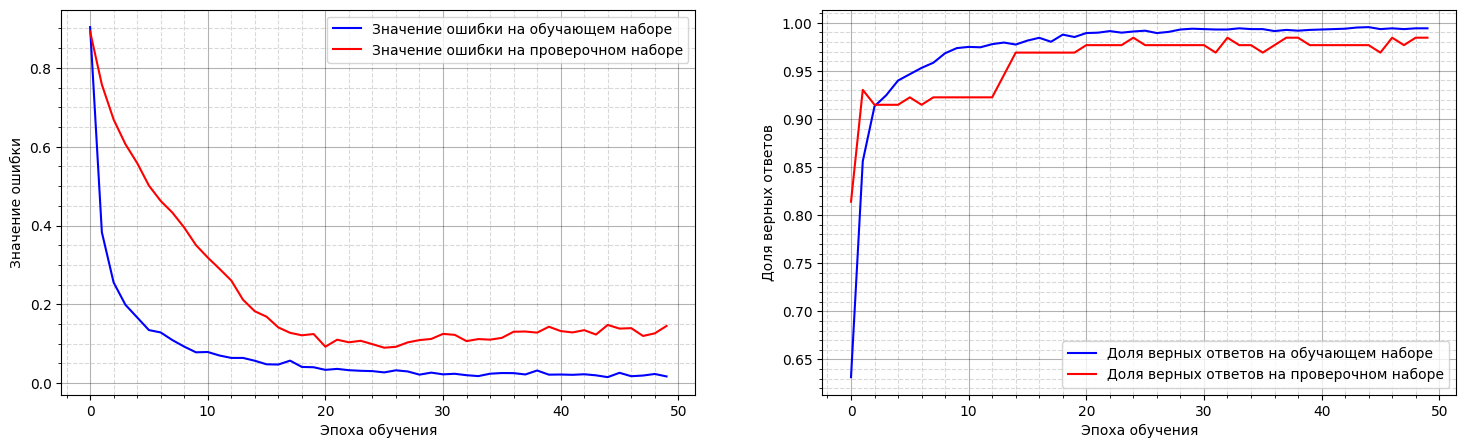

In [ ]:
# Отобразим результаты на графике
printNNChart(history1)

In [ ]:
# Оценим результат работы нашей сети.
# Применим метод .evaluate() к нашей модели, в качестве параметров
# передадим ему тестовые выборки и согласие на отображение хода вычисления.

scores1 = model1.evaluate(x_test,
                          y_test,
                          verbose=1)

print('Процент верных ответов на тестовых данных:', round(scores1[1],2) * 100, '%')

15/15 [==============================] - 0s 4ms/step - loss: 0.2501 - accuracy: 0.9360
Процент верных ответов на тестовых данных: 94.0 %


In [ ]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
print(f'Эпохи: {EPOCHS}')
print("="*50)

# val_accuracy
val_acc1 = history1.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
for i in range(EPOCHS):
  # print(f'{i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc1[i] > val_acc_max:
    val_acc_max = val_acc1[i]
    i_max = i

print(f'Самая точная нейронка под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc1[i]*100., 3)}%')

Эпохи: 50
Самая точная нейронка под номером: 24 из 50 эпох
  достигла точности: 98.45%


## F1Score - статистика предсказаний по тестовой выборке

In [ ]:
# Распознавание ЗаключениеМК на тестовой выборке
# x_test, y_test -> массивы, которые не принимали участия в обучении нейронки
print('x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:')
print('  x_test:')
print('    Количество осей: ',x_test.ndim)
print('    Форма массива: ',x_test.shape)
print('    Количество значений: ',x_test.size)
print('  y_test:')
print('    Количество осей: ',y_test.ndim)
print('    Форма массива: ',y_test.shape)
print('    Количество значений: ',y_test.size)

x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:
  x_test:
    Количество осей:  2
    Форма массива:  (453, 834)
    Количество значений:  377802
  y_test:
    Количество осей:  2
    Форма массива:  (453, 3)
    Количество значений:  1359


In [ ]:
pred1 = model1.predict(x_test)

# У нас три класса:
# 0 - не годен, 1 - ограниченно годен, 2 - годен
# Подсчитаем по каждому верное и неверное предсказания
arr_true = np.zeros(3, dtype=int)
arr_false = np.zeros(3, dtype=int)

for i in range(y_test.shape[0]):
  # Получение индекса самого большого элемента
  # потому что мы имеем дело с one-hot-encoding, поэтому необходимо
  # определить элемент в массиве с максимальным значением,
  # индекс этого элемента и будет говорить о верном элементе
  #~индекс тестового элемента
  y_inx_max = np.argmax(y_test[i,:])
  #~индекс предсказанного элемента
  pred_inx_max = np.argmax(pred1[i,:])
  #~~~
  if y_inx_max == pred_inx_max:
    # верное предсказание
    arr_true[y_inx_max] += 1
  else:
    # неверное предсказания
    arr_false[y_inx_max] += 1

# Результаты предсказаний по тестовой выборке
print('Результаты предсказаний по тестовой выборке:')
print(f'  размер тествой выборки: {y_test.shape[0]}')
print(f'  0 - не годен, предсказания:')
print(f'     верное: {arr_true[0]}')
print(f'     неверное: {arr_false[0]}')
print(f'  1 - ограниченно годен, предсказания:')
print(f'     верное: {arr_true[1]}')
print(f'     неверное: {arr_false[1]}')
print(f'  2 - годен:')
print(f'     верное: {arr_true[2]}')
print(f'     неверное: {arr_false[2]}')

print('проверочная сумма:')

print(f'  {y_test.shape[0]} -> {arr_true[0]+arr_false[0]+arr_true[1]+arr_false[1]+arr_true[2]+arr_false[2]}')

15/15 [==============================] - 0s 2ms/step
Результаты предсказаний по тестовой выборке:
  размер тествой выборки: 453
  0 - не годен, предсказания:
     верное: 150
     неверное: 0
  1 - ограниченно годен, предсказания:
     верное: 91
     неверное: 10
  2 - годен:
     верное: 183
     неверное: 19
проверочная сумма:
  453 -> 453


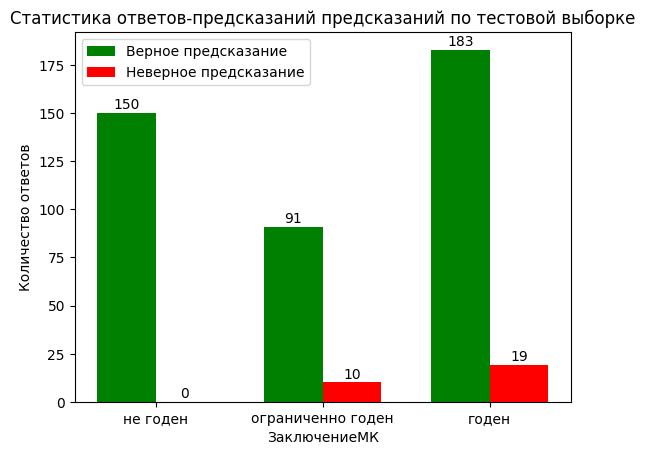

In [ ]:
# conclusion_lst = ['не годен', 'ограниченно годен', 'годен']

fig, ax = plt.subplots()

index = np.arange(len(conclusion_lst))
bar_width = 0.35

rects1 = ax.bar(index, arr_true, bar_width, color='g', label='Верное предсказание')
rects2 = ax.bar(index + bar_width, arr_false, bar_width, color='r', label='Неверное предсказание')

ax.set_xlabel('ЗаключениеМК')
ax.set_ylabel('Количество ответов')
ax.set_title('Статистика ответов-предсказаний предсказаний по тестовой выборке')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(conclusion_lst)

ax.legend()

for rect, value in zip(rects1, arr_true):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for rect, value in zip(rects2, arr_false):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

## Нейронка2 - категориальные+числовые (Модель FunctionalAPI-Составная нейронка)

In [ ]:
print('y_data:')
print('  Количество осей: ',y_data.ndim)
print('  Форма массива: ',y_data.shape)
print('  Количество значений: ',y_data.size)

print('x1_data:')
print('  Количество осей: ',x1_data.ndim)
print('  Форма массива: ',x1_data.shape)
print('  Количество значений: ',x1_data.size)

print('x2_data:')
print('  Количество осей: ',x2_data.ndim)
print('  Форма массива: ',x2_data.shape)
print('  Количество значений: ',x2_data.size)

#~~~~~~~~~~~~~~~~~~~~~~~~
input1 = Input((x1_data.shape[1],))
input2 = Input((x2_data.shape[1],))

#~~~~~~~~~~~~~~~~~~~~~~~~
# Создаем ветку x1
# x1 = BatchNormalization()(input1) # Создаем ветку x1
# x1 = Dropout(0.5)(x1)
# x1 = Dense(10, activation="relu")(x1)
# x1 = Dense(1000, activation="relu")(x1)
# x1 = Dense(100, activation = "relu")(x1)

x1 = Dense(60, activation="relu")(input1)

x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(30, activation="relu")(x1)

x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(10, activation="relu")(x1)

#~~~~~~~~~~~~~~~~~~~~~~~~
# Создаем ветку x2
x2 = Dense(60, activation="relu")(input2)

x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(30, activation="relu")(x2)

x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(10, activation="relu")(x2)

#~~~~~~~~~~~~~~~~~~~~~~~~
# Объединяем все две(три) ветки
x = concatenate([x1, x2])
x = Dense(5, activation='relu')(x)
x = Dropout(0.5)(x)
# Финальные нейроны
x = Dense(3, activation='softmax')(x)

#~~~~~~~~~~~~~~~~~~~~~~~~
# В Model загружаем стартовые и последнюю точки
model2 = Model((input1, input2), x)


y_data:
  Количество осей:  2
  Форма массива:  (3014, 3)
  Количество значений:  9042
x1_data:
  Количество осей:  2
  Форма массива:  (3014, 834)
  Количество значений:  2513676
x2_data:
  Количество осей:  2
  Форма массива:  (3014, 2)
  Количество значений:  6028


In [ ]:
# Компиляция
model2.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=LEARNING_RATE),
               metrics=['accuracy'])

In [ ]:
splitter90 = int(x1_data.shape[0]*(1. - VALID_DATA_SIZE))

print(f'x1_data число строк : {x1_data.shape[0]}')
print(f'x1_data число столбцов : {x1_data.shape[1]}')
print(f'splitter90: {splitter90}')

x1_data число строк : 3014
x1_data число столбцов : 834
splitter90: 2863


In [ ]:
# history2 = model2.fit([xTrain01[:50000], xTrainRez01[:50000]],
#                     yTrain[:50000],
#                     epochs= 80,
#                     validation_data=([xTrain01[50000:], xTrainRez01[50000:]],
#                     yTrain[50000:]),
#                     verbose=1, shuffle=True)

history2 = model2.fit([x1_data[:splitter90], x2_data[:splitter90]],
                      y_data[:splitter90],
                      epochs= EPOCHS,
                      validation_data=([x1_data[splitter90:], x2_data[splitter90:]],
                      y_data[splitter90:]),
                      verbose=VERBOSE)

Epoch 1/50
90/90 [==============================] - 6s 9ms/step - loss: 1.1038 - accuracy: 0.5253 - val_loss: 1.0196 - val_accuracy: 0.5033
Epoch 2/50
90/90 [==============================] - 0s 5ms/step - loss: 0.8316 - accuracy: 0.6214 - val_loss: 0.9478 - val_accuracy: 0.5033
Epoch 3/50
90/90 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.6818 - val_loss: 0.6728 - val_accuracy: 0.6689
Epoch 4/50
90/90 [==============================] - 0s 5ms/step - loss: 0.6168 - accuracy: 0.7042 - val_loss: 0.4424 - val_accuracy: 0.7947
Epoch 5/50
90/90 [==============================] - 0s 5ms/step - loss: 0.5939 - accuracy: 0.7031 - val_loss: 0.3966 - val_accuracy: 0.7947
Epoch 6/50
90/90 [==============================] - 0s 5ms/step - loss: 0.5402 - accuracy: 0.7279 - val_loss: 0.3562 - val_accuracy: 0.7947
Epoch 7/50
90/90 [==============================] - 0s 5ms/step - loss: 0.5090 - accuracy: 0.7279 - val_loss: 0.3264 - val_accuracy: 0.9205
Epoch 8/50
90/90 [==

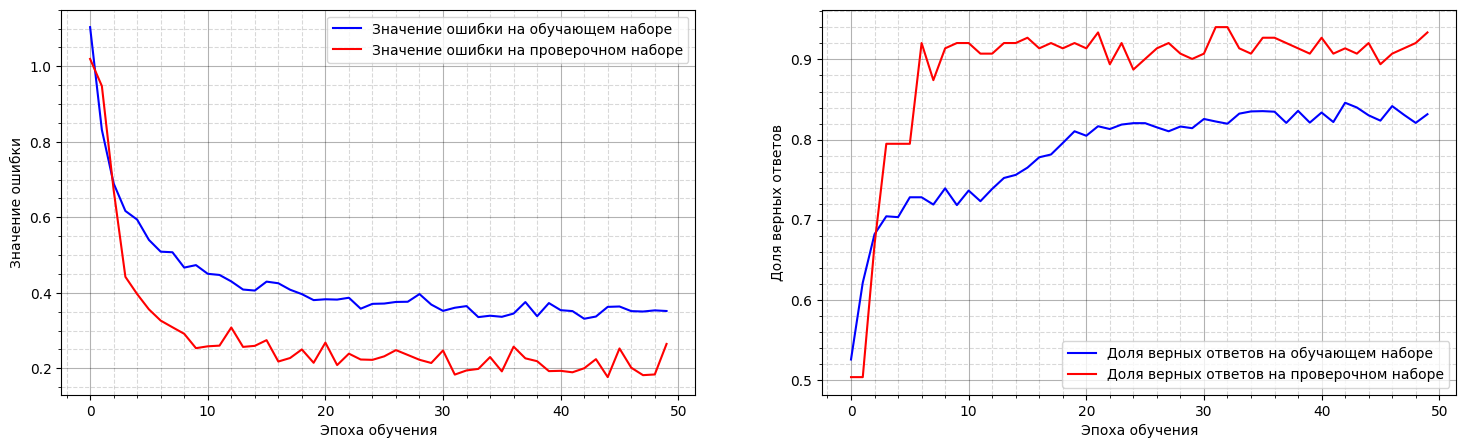

In [ ]:
# Отобразим результаты на графике
printNNChart(history2)

In [ ]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
print(f'Эпохи: {EPOCHS}')
print("="*50)

# val_accuracy
val_acc2 = history2.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
for i in range(EPOCHS):
  # print(f'{i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc2[i] > val_acc_max:
    val_acc_max = val_acc2[2]
    i_max = i

print(f'Самая точная нейронка под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc2[i]*100., 3)}%')

Эпохи: 50
Самая точная нейронка под номером: 49 из 50 эпох
  достигла точности: 93.377%
